In [1]:
import os
prefix = "/home/kreffert/"
# prefix = "/pfs/data6/home/ma/ma_ma/ma_kreffert/" 
os.chdir(f'{prefix}Probabilistic_LTSF/BasicTS/')
from basicts.metrics import masked_mae, masked_mse, nll_loss, crps, Evaluator, quantile_loss, empirical_crps
from easytorch.device import set_device_type
from easytorch.utils import get_logger, set_visible_devices
# set the device type (CPU, GPU, or MLU)
device_type ='gpu'
gpus = '0'
set_device_type(device_type)
set_visible_devices(gpus)
from easydict import EasyDict
from tqdm import tqdm

# extract the paths to the configs and weights
import yaml
# /home/kreffert/Probabilistic_LTSF/notebooks/Final plots/weights.yaml
with open(f'{prefix}Probabilistic_LTSF/notebooks/Final plots/weights.yaml', 'r') as file:
    _configs = yaml.safe_load(file)
    
def reconstruct_paths(
    simplified_dict,
    _dataset=['ETTh1', 'ETTm1'],
    _models=['DLinear', 'PatchTST', 'DeepAR'],
    _dists=['q', 'iq', 'u', 'm'],
    _seeds=[0, 1, 2, 3, 4],
    _model_dist_map=None  # optional: {'DLinear': ['m'], 'DeepAR': ['u']}
):
    base_path = "final_weights/"
    dist_mapping = {"iq": "i_quantile", "u": "univariate", "m": "multivariate", "q": "quantile"}
    filtered_dict = {}

    for dataset, models in simplified_dict.items():
        if dataset not in _dataset:
            continue
        for model, dists in models.items():
            if _model_dist_map:
                if model not in _model_dist_map:
                    continue
            elif model not in _models:
                continue

            allowed_dists = _model_dist_map[model] if _model_dist_map else _dists

            for dist, seeds in dists.items():
                if dist not in allowed_dists:
                    continue
                _cfg = f"{dataset}_prob_quantile.py" if dist in ["q", "iq"] else f"{dataset}_prob.py"
                _ckpt = "_best_val_QL.pt" if dist in ["q", "iq"] else "_best_val_NLL.pt"
                mapped_dist = dist_mapping.get(dist, dist)

                for seed, path_suffix in seeds.items():
                    if seed not in _seeds or path_suffix is None:
                        continue
                    prefix = f"{base_path}{dataset}/{model}/{mapped_dist}/{seed}/{path_suffix}"
                    ckpt_path = f"{prefix}/{model}{_ckpt}"
                    if os.path.isfile(ckpt_path): # check if samples where created as well?
                        filtered_dict.setdefault(dataset, {}).setdefault(model, {}).setdefault(dist, {})[seed] = {
                            'cfg': f"{prefix}/{_cfg}",
                            'ckpt': f"{prefix}/{model}{_ckpt}"
                        }
                    # else:
                    #     print(f"{ckpt_path} not found.")

    return filtered_dict



_model_dist_map={'DLinear': ['m'], 'DeepAR': ['u']}
_models = ['DeepAR'] #full_dict[dataset][model][dist][random_state]
_dataset = ['ETTm1']
_dists = ['iq']#['u', 'm', 'q', 'iq']
_seeds = [2]
# _configs = reconstruct_paths(_configs, _dataset=_dataset, _models=_models, _dists=_dists, _seeds=_seeds, _model_dist_map=_model_dist_map)
_configs = reconstruct_paths(_configs, _dataset=_dataset, _models=_models) #, _dists=_dists)

2025-07-12 13:15:31,347 - easytorch-env - INFO - Use devices 0.


# eval

In [2]:
# evaluate the model_return pickle files
# evaluate the models
import torch
def vs_ensemble_torch(obs, fct, p=1.0):
    """
    Compute Variogram Score using PyTorch on GPU.
    obs: shape (..., D)
    fct: shape (..., M, D)
    """
    M = fct.shape[-2]

    # Compute ensemble variogram component
    fct_diff = fct.unsqueeze(-2) - fct.unsqueeze(-1)  # (B, M, D, D)
    # print(fct_diff.shape)
    vfct = (fct_diff.abs() ** p).sum(dim=-3) / M  # (B, D, D)
    # print(vfct.shape)
    # Compute observed variogram component
    obs_diff = obs.unsqueeze(-2) - obs.unsqueeze(-1)  # (B, D, D)
    vobs = (obs_diff.abs() ** p)  # (B, D, D)
    # print(vobs.shape)
    # print(vfct.shape)
    vs = ((vfct - vobs) ** 2).sum(dim=(-2, -1))  # (B,)
    return vs

def es_ensemble_torch(obs: torch.Tensor, fct: torch.Tensor) -> torch.Tensor:
    """
    Compute the energy score using PyTorch.
    
    Parameters:
    - obs: Tensor of shape (B, D)
    - fct: Tensor of shape (B, M, D)

    Returns:
    - Tensor of shape (B,) with energy scores
    """
    M = fct.shape[-2]

    # E_1: mean norm between forecast samples and the observation
    err_norm = torch.norm(fct - obs.unsqueeze(-2), dim=-1)  # (B, M)
    E_1 = err_norm.sum(dim=-1) / M  # (B,)

    # E_2: mean pairwise distance between forecast samples
    spread = fct.unsqueeze(-3) - fct.unsqueeze(-2)  # (B, M, M, D)
    spread_norm = torch.norm(spread, dim=-1)  # (B, M, M)
    E_2 = spread_norm.sum(dim=(-2, -1)) / (M**2) # (B,)

    return E_1 - 0.5 * E_2  # (B,)


def coverage(y, forecast):
    return np.mean(forecast >= y)
    
def sharpness(lower, upper, y):
    y_safe = np.where(np.abs(y) == 0, 1e-7, np.abs(y))  # Avoid division by zero
    return np.mean((upper - lower) / y_safe)

def quantile_score(y, forecast, alpha):
    """
    Quantile score for a given quantile level (alpha).
    Lower is better.
    """
    return np.mean(2 * ((y < forecast) - alpha) * (forecast - y))

def interval_score(y, lower, upper, alpha):
    """
    Interval score for central prediction intervals.
    Lower is better.
    """
    return np.mean((upper - lower) + 
                   (2 / alpha) * (lower - y) * (y < lower) + 
                   (2 / alpha) * (y - upper) * (y > upper))

def weighted_quantile_score(y, forecast_quantiles, quantile_levels):
    """
    Computes the weighted Quantile Score (wQS).
    y: array of shape (D,)
    forecast_quantiles: array of shape (len(quantile_levels), D)
    """
    D = y.shape[0]
    qs_sum = 0
    for i, alpha in enumerate(quantile_levels):
        qs = quantile_score(y, forecast_quantiles[i], alpha)
        qs_sum += qs
    y = np.where(np.abs(y) == 0, 1e-7, np.abs(y))  # Avoid division by zero
    wqs = qs_sum / np.mean(np.abs(y)) if np.sum(np.abs(y)) != 0 else np.nan
    return wqs / len(quantile_levels)


def weighted_interval_score(y, forecast_quantiles, interval_bounds):
    """
    Computes the Weighted Interval Score (WIS).
    y: array of shape (D,)
    forecast_quantiles: array of shape (len(quantile_levels), D)
    interval_bounds: dict like {0.5: (0.25, 0.75), ...}
    """
    quantile_levels = [0.005, 0.025, 0.165, 0.25, 0.5, 0.75, 0.835, 0.975, 0.995]
    median = forecast_quantiles[quantile_levels.index(0.5)]
    wis = 0.5 * np.mean(np.abs(y - median))  # w0 * |y - median|

    for alpha in interval_bounds:
        lower_idx = quantile_levels.index(interval_bounds[alpha][0])
        upper_idx = quantile_levels.index(interval_bounds[alpha][1])
        lower = forecast_quantiles[lower_idx]
        upper = forecast_quantiles[upper_idx]
        iscore = interval_score(y, lower, upper, alpha=1 - alpha)
        wis += (1 - alpha) * iscore / 2  # wk = alpha/2 = (1 - alpha)/2

    K = len(interval_bounds)
    return wis / (K + 0.5)

In [3]:
import numpy as np
import pickle
import torch
import scoringrules as sr
import gzip
def _evaluate(target, samples, dist=None):
    # Create DataLoader
    device = 'cuda:0'
    quantile_levels = [0.005, 0.025, 0.165, 0.25, 0.5, 0.75, 0.835, 0.975, 0.995]
    interval_bounds = {0.5: (0.25, 0.75), 0.67: (0.165, 0.835), 0.95: (0.025, 0.975), 0.99: (0.005, 0.995)}
    
    metrics = ['crps', 'crps_sum', 'crps_sum_q', 'crps_q', 'vs_05', 'vs_1', 'vs_2', 'es', 'wqs', 'wis', 'mae', 'mse']
    metrics = metrics + [f"{m}{quantile}" for quantile in quantile_levels for m in ['coverage_', 'qs_']]
    metrics = metrics + [f"{m}{interval}" for interval in interval_bounds.keys() for m in ['sharpness_', 'is_']]
    
    
    results = {}
    for metric in metrics:
        results[metric] = [] 
    from torch.utils.data import TensorDataset, DataLoader
    batch_size = 64
    dataset = TensorDataset(samples, target)
    data_iter = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    # for iter_index, (samples_batch, target_batch) in tqdm(enumerate(data_iter), total=len(data_iter)):
    for iter_index, (samples_batch, target_batch) in enumerate(data_iter):
        samples_batch = samples_batch.to(device)#.permute(0, 2, 3, 1)
        target_batch = target_batch.to(device).squeeze(-1)
        if dist not in ['quantile']:
            results['crps'].append(np.mean(sr.crps_ensemble(target_batch.detach().cpu(), samples_batch.detach().cpu(), estimator='pwm')))
            results['crps_sum'] = np.mean(sr.crps_ensemble(target_batch.detach().cpu().sum(axis=-1), samples_batch.detach().cpu().sum(axis=-2), estimator='pwm'))
        
            # prediction=s
            samples_batch = samples_batch.permute(0, 1, 3, 2)
            results['vs_05'].append(torch.mean(vs_ensemble_torch(target_batch.to(device), samples_batch.to(device), p=0.5)).cpu().numpy())
            # vs_1 = np.mean(sr.variogram_score(target.permute(0, 2, 1), samples.permute(0, 2, 3, 1), p=1.0, backend='numba'))
            results['vs_1'].append(torch.mean(vs_ensemble_torch(target_batch.to(device), samples_batch.to(device), p=1)).cpu().numpy())
            results['vs_2'].append(torch.mean(vs_ensemble_torch(target_batch.to(device), samples_batch.to(device), p=2)).cpu().numpy())
            results['es'].append(torch.mean(es_ensemble_torch(target_batch.to(device), samples_batch.to(device))).cpu().numpy())
            
            # # now determine the quantiles of the forecasts and determine the quantile metrics
            samples_batch = samples_batch.permute(0, 1, 3, 2).cpu().numpy()
            quantiles_sum = np.quantile(samples_batch.sum(axis=-2), quantile_levels, axis=-1)
            quantiles = np.quantile(samples_batch, quantile_levels, axis=-1)
        else:
            quantiles = samples_batch.permute(3, 0, 1, 2).cpu().numpy()
            quantiles_sum = quantiles.sum(axis=-1)
            
        target_batch = target_batch.cpu().numpy()
        results['crps_sum_q'].append(np.mean(sr.crps_quantile(target_batch.sum(axis=-1), np.transpose(quantiles_sum, (1, 2, 0)), quantile_levels)))
        results['crps_q'].append(np.mean(sr.crps_quantile(target_batch, np.transpose(quantiles, (1, 2, 3, 0)), quantile_levels)))
        
        # # evaluate interval metrics
        for interval in interval_bounds.keys():
            lower = torch.tensor(quantiles[quantile_levels.index(interval_bounds[interval][0])]).numpy()
            upper = torch.tensor(quantiles[quantile_levels.index(interval_bounds[interval][1])]).numpy()
            results[f'sharpness_{interval}'].append(sharpness(lower, upper, target_batch))
            results[f'is_{interval}'].append(interval_score(target_batch, lower, upper, alpha=1 - interval))
    
        for quantile in quantile_levels:
            forecast = quantiles[quantile_levels.index(quantile)]
            results[f'coverage_{quantile}'].append(coverage(target_batch, forecast))
            results[f'qs_{quantile}'].append(quantile_score(target_batch, forecast, alpha=quantile))

        median_forecast = quantiles[quantile_levels.index(0.5)]
        results['mse'].append(np.mean((target_batch - median_forecast) ** 2))
        results['mae'].append(np.mean(np.abs(target_batch - median_forecast)))
    
        # # Compute WQS and WIS
        results['wqs'].append(weighted_quantile_score(target_batch, quantiles, quantile_levels))
        results['wis'].append(weighted_interval_score(target_batch, quantiles, interval_bounds))
        
    for metric in results.keys():
        results[metric] = round(np.mean(results[metric]), 4)
    return results


from collections import defaultdict
from tqdm import tqdm
import gc

def evaluate(_datasets=['ETTh1', 'ETTm1'],
             _models=['DLinear', 'PatchTST', 'DeepAR'],
             _dists=['quantile', 'i_quantile', 'univariate', 'multivariate'],
             _seeds=[0, 1, 2, 3, 4]):
    
    for dataset in _datasets:
        with  gzip.open(f'/work/kreffert/Probabilistic_LTSF/BasicTS/final_weights/{dataset}/target.pkl.gz', 'rb') as f:
            target = pickle.load(f)
        for model in _models:
            for dist in _dists:
                prefix = 'work'
                if model == 'DLinear':
                    prefix = 'ceph'
                
                path = f"/{prefix}/kreffert/Probabilistic_LTSF/BasicTS/final_weights/{dataset}/{model}/{dist}"
                if os.path.isfile(f"{path}/evaluation.pkl"):
                    print(f'Model return already available {path}/evaluation.pkl')
                    with open(f'{path}/evaluation.pkl', 'rb') as f:
                        final_results = pickle.load(f)
                else:
                    all_results = []  # collect each run's metrics
                    for random_state in tqdm(_seeds, desc=f"{dataset}/{model}/{dist}"):
                        path = f"/{prefix}/kreffert/Probabilistic_LTSF/BasicTS/final_weights/{dataset}/{model}/{dist}/{random_state}/model_return.pt.gz"
                        
                        if os.path.isfile(path):
                            with gzip.open(path, 'rb') as f:
                                model_return = torch.load(f)
                            # tqdm.write(f"Loaded {dataset}/{model}/{dist}/{random_state}")
    
                            # tqdm.write(f"Loaded {dataset}/{model}/{dist}/{random_state}")
                            if dist not in ['quantile']:
                                samples = model_return['samples']
                            else:
                                samples = model_return['prediction']
                            del model_return
                            gc.collect()
                            torch.cuda.empty_cache()
                            # target = model_return['target']
                            run_result = _evaluate(target, samples, dist=dist)
                            all_results.append(run_result)
                            del samples
                            gc.collect()
                            torch.cuda.empty_cache()
                        else:
                            print(f"Missing: {path}")
                            continue
    
                    # Convert list of dicts to dict of lists
                    combined = defaultdict(list)
                    for res in all_results:
                        for k, v in res.items():
                            combined[k].append(v)
    
                    # Compute mean and std
                    final_results = {
                        k: {
                            'mean': round(float(np.mean(v)), 4),
                            'std': round(float(np.std(v)), 4)
                        } for k, v in combined.items()
                    }
                    path = f"/{prefix}/kreffert/Probabilistic_LTSF/BasicTS/final_weights/{dataset}/{model}/{dist}"
                    with open(f'{path}/evaluation.pkl', 'wb') as f:
                        pickle.dump(final_results, f)

                print(f"\nFinal averaged results for {dataset}/{model}/{dist}:\n")
                for metric, values in final_results.items():
                    print(f"{metric}: {values['mean']} ± {values['std']}")

evaluate(_datasets=['ETTm1'])

Model return already available /ceph/kreffert/Probabilistic_LTSF/BasicTS/final_weights/ETTm1/DLinear/quantile/evaluation.pkl

Final averaged results for ETTm1/DLinear/quantile:

crps: nan ± nan
crps_sum: nan ± nan
crps_sum_q: 3.9132 ± 0.0146
crps_q: 0.8286 ± 0.0014
vs_05: nan ± nan
vs_1: nan ± nan
vs_2: nan ± nan
es: nan ± nan
wqs: 0.1794 ± 0.0003
wis: 0.8286 ± 0.0014
mae: 1.6143 ± 0.001
mse: 10.2004 ± 0.0262
coverage_0.005: 0.0152 ± 0.0002
qs_0.005: 0.1171 ± 0.0016
coverage_0.025: 0.0335 ± 0.0008
qs_0.025: 0.4094 ± 0.0032
coverage_0.165: 0.1434 ± 0.0021
qs_0.165: 1.1917 ± 0.0024
coverage_0.25: 0.2223 ± 0.0019
qs_0.25: 1.4087 ± 0.0018
coverage_0.5: 0.4762 ± 0.0042
qs_0.5: 1.6143 ± 0.001
coverage_0.75: 0.7391 ± 0.0061
qs_0.75: 1.2917 ± 0.0014
coverage_0.835: 0.8274 ± 0.0056
qs_0.835: 1.0178 ± 0.0014
coverage_0.975: 0.96 ± 0.0016
qs_0.975: 0.2865 ± 0.0017
coverage_0.995: 0.9743 ± 0.0007
qs_0.995: 0.1208 ± 0.0012
sharpness_0.5: 169013.8281 ± 3506.2712
is_0.5: 5.4008 ± 0.0045
sharpness_0.6

ETTm1/DeepAR/i_quantile: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [1:34:51<00:00, 1138.21s/it]



Final averaged results for ETTm1/DeepAR/i_quantile:

crps: 3.6052 ± 1.2041
crps_sum: 19.0968 ± 12.2848
crps_sum_q: 13.6429 ± 9.0914
crps_q: 2.6041 ± 0.9996
vs_05: 72.8532 ± 32.2022
vs_1: 2493.1902 ± 1942.467
vs_2: 2105984.5 ± 2815816.5
es: 14.9837 ± 5.5826
wqs: 0.564 ± 0.2177
wis: 2.6041 ± 0.9996
mae: 4.799 ± 1.449
mse: 69.4847 ± 49.8926
coverage_0.005: 0.1028 ± 0.09
qs_0.005: 1.2152 ± 1.2591
coverage_0.025: 0.179 ± 0.1386
qs_0.025: 1.9209 ± 1.5376
coverage_0.165: 0.4226 ± 0.2657
qs_0.165: 4.2078 ± 1.9685
coverage_0.25: 0.4834 ± 0.294
qs_0.25: 4.7204 ± 1.9065
coverage_0.5: 0.5916 ± 0.3122
qs_0.5: 4.799 ± 1.449
coverage_0.75: 0.6913 ± 0.2668
qs_0.75: 3.3393 ± 0.7444
coverage_0.835: 0.7449 ± 0.2267
qs_0.835: 2.4883 ± 0.4672
coverage_0.975: 0.9029 ± 0.0943
qs_0.975: 0.5626 ± 0.1207
coverage_0.995: 0.9492 ± 0.0544
qs_0.995: 0.1835 ± 0.0994
sharpness_0.5: 351905.6147 ± 176769.4847
is_0.5: 16.1194 ± 5.1029
sharpness_0.67: 507164.2207 ± 224769.1451
is_0.67: 20.2912 ± 6.9998
sharpness_0.95: 1

ETTm1/DeepAR/multivariate: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12595.51it/s]


Missing: /work/kreffert/Probabilistic_LTSF/BasicTS/final_weights/ETTm1/DeepAR/multivariate/0/model_return.pt.gz
Missing: /work/kreffert/Probabilistic_LTSF/BasicTS/final_weights/ETTm1/DeepAR/multivariate/1/model_return.pt.gz
Missing: /work/kreffert/Probabilistic_LTSF/BasicTS/final_weights/ETTm1/DeepAR/multivariate/2/model_return.pt.gz
Missing: /work/kreffert/Probabilistic_LTSF/BasicTS/final_weights/ETTm1/DeepAR/multivariate/3/model_return.pt.gz
Missing: /work/kreffert/Probabilistic_LTSF/BasicTS/final_weights/ETTm1/DeepAR/multivariate/4/model_return.pt.gz


FileNotFoundError: [Errno 2] No such file or directory: '/work/kreffert/Probabilistic_LTSF/BasicTS/final_weights/ETTm1/DeepAR/multivariate/evaluation.pkl'

In [ ]:
import scoringrules as sr
from tqdm import tqdm
import numpy as np
paths = ['/pfs/data6/home/ma/ma_ma/ma_kreffert/Probabilistic_LTSF/BasicTS/final_weightsETTh1/DeepAR/univariate/2/model_return.pkl',
        '/pfs/data6/home/ma/ma_ma/ma_kreffert/Probabilistic_LTSF/BasicTS/final_weightsETTh1/DLinear/multivariate/2/model_return.pkl']

    
device = 'cuda:0'
quantile_levels = [0.005, 0.025, 0.165, 0.25, 0.5, 0.75, 0.835, 0.975, 0.995]
interval_bounds = {0.5: (0.25, 0.75), 0.67: (0.165, 0.835), 0.95: (0.025, 0.975), 0.99: (0.005, 0.995)}

metrics = ['crps', 'crps_sum', 'crps_sum_q', 'crps_q', 'vs_05', 'vs_1', 'vs_2', 'es', 'wqs', 'wis']
metrics = metrics + [f"{m}{quantile}" for quantile in quantile_levels for m in ['coverage_', 'qs_']]
metrics = metrics + [f"{m}{interval}" for interval in interval_bounds.keys() for m in ['sharpness_', 'is_']]


results = {}
for metric in metrics:
    results[metric] = [] 

path=paths[0]
with open(path, 'rb') as f:
    model_return = pickle.load(f)
# inputs = model_return['inputs'].to(device)
target = model_return['target'].to(device)
samples = model_return['samples'].to(device)
# Create DataLoader
from torch.utils.data import TensorDataset, DataLoader
batch_size = 64
dataset = TensorDataset(samples, target)
data_iter = DataLoader(dataset, batch_size=batch_size, shuffle=False)
for iter_index, (samples_batch, target_batch) in tqdm(enumerate(data_iter), total=len(data_iter)):
    samples_batch = samples_batch.to(device)#.permute(0, 2, 3, 1)
    target_batch = target_batch.to(device).squeeze(-1)
    results['crps'].append(np.mean(sr.crps_ensemble(target_batch.detach().cpu(), samples_batch.detach().cpu(), estimator='pwm')))
    results['crps_sum'] = np.mean(sr.crps_ensemble(target_batch.detach().cpu().sum(axis=-1), samples_batch.detach().cpu().sum(axis=-2), estimator='pwm'))
    
    # prediction=s
    samples_batch = samples_batch.permute(0, 1, 3, 2)
    results['vs_05'].append(torch.mean(vs_ensemble_torch(target_batch.to(device), samples_batch.to(device), p=0.5)).cpu().numpy())
    # vs_1 = np.mean(sr.variogram_score(target.permute(0, 2, 1), samples.permute(0, 2, 3, 1), p=1.0, backend='numba'))
    results['vs_1'].append(torch.mean(vs_ensemble_torch(target_batch.to(device), samples_batch.to(device), p=1)).cpu().numpy())
    results['vs_2'].append(torch.mean(vs_ensemble_torch(target_batch.to(device), samples_batch.to(device), p=2)).cpu().numpy())
    results['es'].append(torch.mean(es_ensemble_torch(target_batch.to(device), samples_batch.to(device))).cpu().numpy())
    
    # # now determine the quantiles of the forecasts and determine the quantile metrics
    samples_batch = samples_batch.permute(0, 1, 3, 2).cpu().numpy()
    target_batch = target_batch.cpu().numpy()
    
    quantiles = np.quantile(samples_batch.sum(axis=-2), quantile_levels, axis=-1)
    results['crps_sum_q'].append(np.mean(sr.crps_quantile(target_batch.sum(axis=-1), np.transpose(quantiles, (1, 2, 0)), quantile_levels)))
    
    quantiles = np.quantile(samples_batch, quantile_levels, axis=-1)
    results['crps_q'].append(np.mean(sr.crps_quantile(target_batch, np.transpose(quantiles, (1, 2, 3, 0)), quantile_levels)))
    
    # # evaluate interval metrics
    for interval in interval_bounds.keys():
        lower = torch.tensor(quantiles[quantile_levels.index(interval_bounds[interval][0])]).numpy()
        upper = torch.tensor(quantiles[quantile_levels.index(interval_bounds[interval][1])]).numpy()
        results[f'sharpness_{interval}'].append(sharpness(lower, upper, target_batch))
        results[f'is_{interval}'].append(interval_score(target_batch, lower, upper, alpha=1 - interval))

    for quantile in quantile_levels:
        forecast = quantiles[quantile_levels.index(quantile)]
        results[f'coverage_{quantile}'].append(coverage(target_batch, forecast))
        results[f'qs_{quantile}'].append(quantile_score(target_batch, forecast, alpha=quantile))

    # # Compute WQS and WIS
    results['wqs'].append(weighted_quantile_score(target_batch, quantiles, quantile_levels))
    results['wis'].append(weighted_interval_score(target_batch, quantiles, interval_bounds))
    
for metric in results.keys():
    results[metric] = round(np.mean(results[metric]), 4)
print(results)

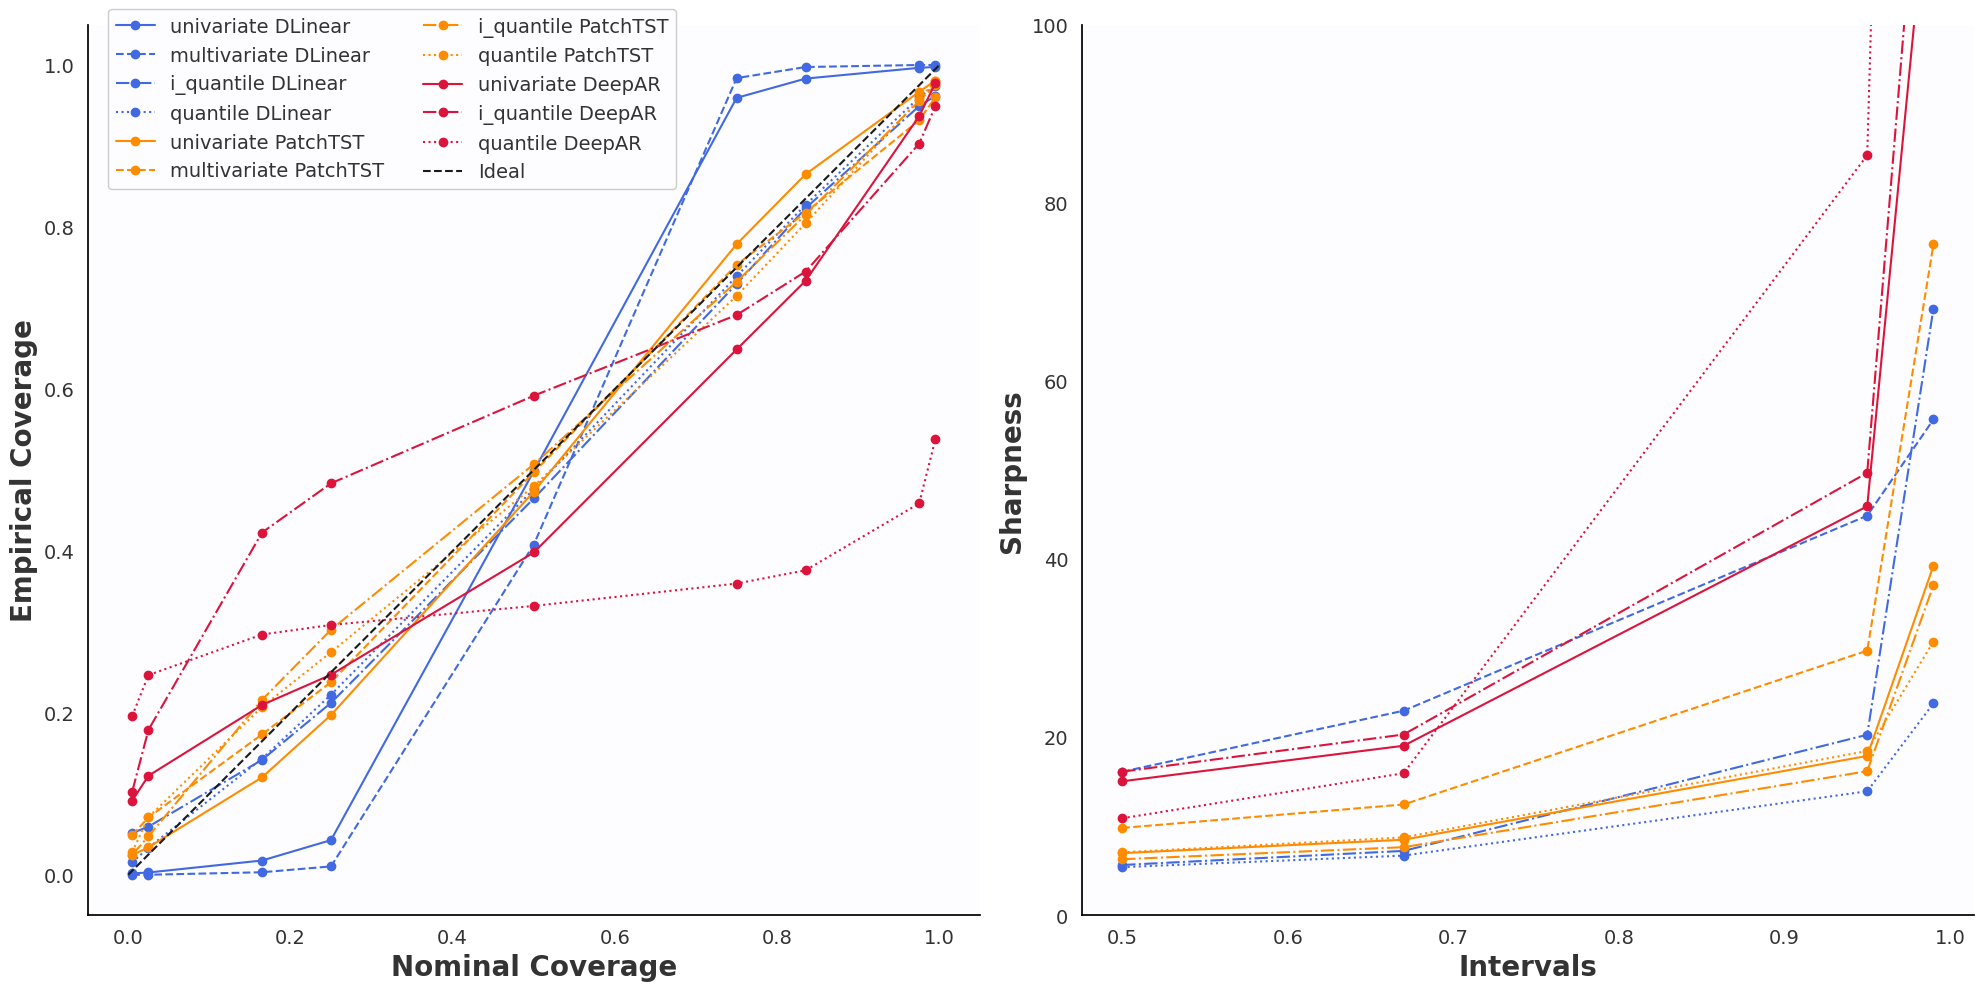

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os

# Define quantile levels and sharpness intervals
quantile_levels = [0.005, 0.025, 0.165, 0.25, 0.5, 0.75, 0.835, 0.975, 0.995]
sharpness_intervals = [0.5, 0.67, 0.95, 0.99]

# Style settings
custom_text_color = "#333333"
custom_bg = "#FDFDFF"
custom_theme = {
    'axes.facecolor': custom_bg,
    'axes.edgecolor': 'black',
    'axes.grid': False,
    'grid.color': '#dcdcdc',
    'xtick.color': custom_text_color,
    'ytick.color': custom_text_color,
    'axes.labelcolor': custom_text_color,
    'text.color': custom_text_color
}
sns.set_theme(style='white')
sns.set_style("white", rc=custom_theme)

# Set up plot
fig, axs = plt.subplots(ncols=2, figsize=(20, 10))
colors = {
    'DeepAR': "#DC143C",
    'DLinear': "#4169E1",
    'PatchTST': "#FF8C00",
}
linestyle = {
    'univariate': "-",
    'multivariate': "--",
    'quantile': ":",
    'i_quantile': '-.'
}

_models=['DLinear', 'PatchTST', 'DeepAR'] # 'PatchTSTg']
_dists=['univariate', 'multivariate', 'i_quantile', 'quantile']
dataset = 'ETTm1'
# --- Coverage Plot ---
for model in _models:
    for dist in _dists:
        prefix='work'
        if model == 'DLinear':
            prefix = 'ceph'
        path = f"/{prefix}/kreffert/Probabilistic_LTSF/BasicTS/final_weights/{dataset}/{model}/{dist}/evaluation.pkl"
        if os.path.isfile(path):
            with open(path, 'rb') as f:
                results = pickle.load(f)
                
            empirical_coverage = [
                results[f'coverage_{q}']['mean'] for q in quantile_levels
            ]
            axs[0].plot(quantile_levels, empirical_coverage, marker='o',
                        color=colors[model], linestyle=linestyle[dist], label=f"{dist} {model}")

# Ideal coverage line
axs[0].plot([0, 1], [0, 1], 'k--', label='Ideal')
axs[0].set_xlabel("Nominal Coverage", fontsize=20, fontweight='bold')
axs[0].set_ylabel("Empirical Coverage", fontsize=20, fontweight='bold')

# --- Sharpness Plot ---
for model in _models:
    for dist in _dists:
        prefix='work'
        if model == 'DLinear':
            prefix = 'ceph'
        path = f"/{prefix}/kreffert/Probabilistic_LTSF/BasicTS/final_weights/{dataset}/{model}/{dist}/evaluation.pkl"
        if os.path.isfile(path):
            with open(path, 'rb') as f:
                results = pickle.load(f)
            sharpness = [
                results[f'is_{i}']['mean'] for i in sharpness_intervals
            ]
            axs[1].plot(sharpness_intervals, sharpness, marker='o',
                        color=colors[model], linestyle=linestyle[dist], label=f"{dist} {model}")

axs[1].set_xlabel("Intervals", fontsize=20, fontweight='bold')
axs[1].set_ylabel("Sharpness", fontsize=20, fontweight='bold')
axs[1].set_ylim(0, 100)

# Formatting
for ax in axs:
    ax.tick_params(axis='both', labelsize=14)

# Layout and legend
plt.tight_layout()
sns.despine(left=False, bottom=False)
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=2, bbox_to_anchor=(0.2, 0.8),
           fontsize=14, frameon=True, framealpha=1)

plt.savefig("/home/kreffert/Probabilistic_LTSF/notebooks/Coverage_and_sharpness.pdf", format='pdf', dpi=600, bbox_inches='tight')
plt.show()

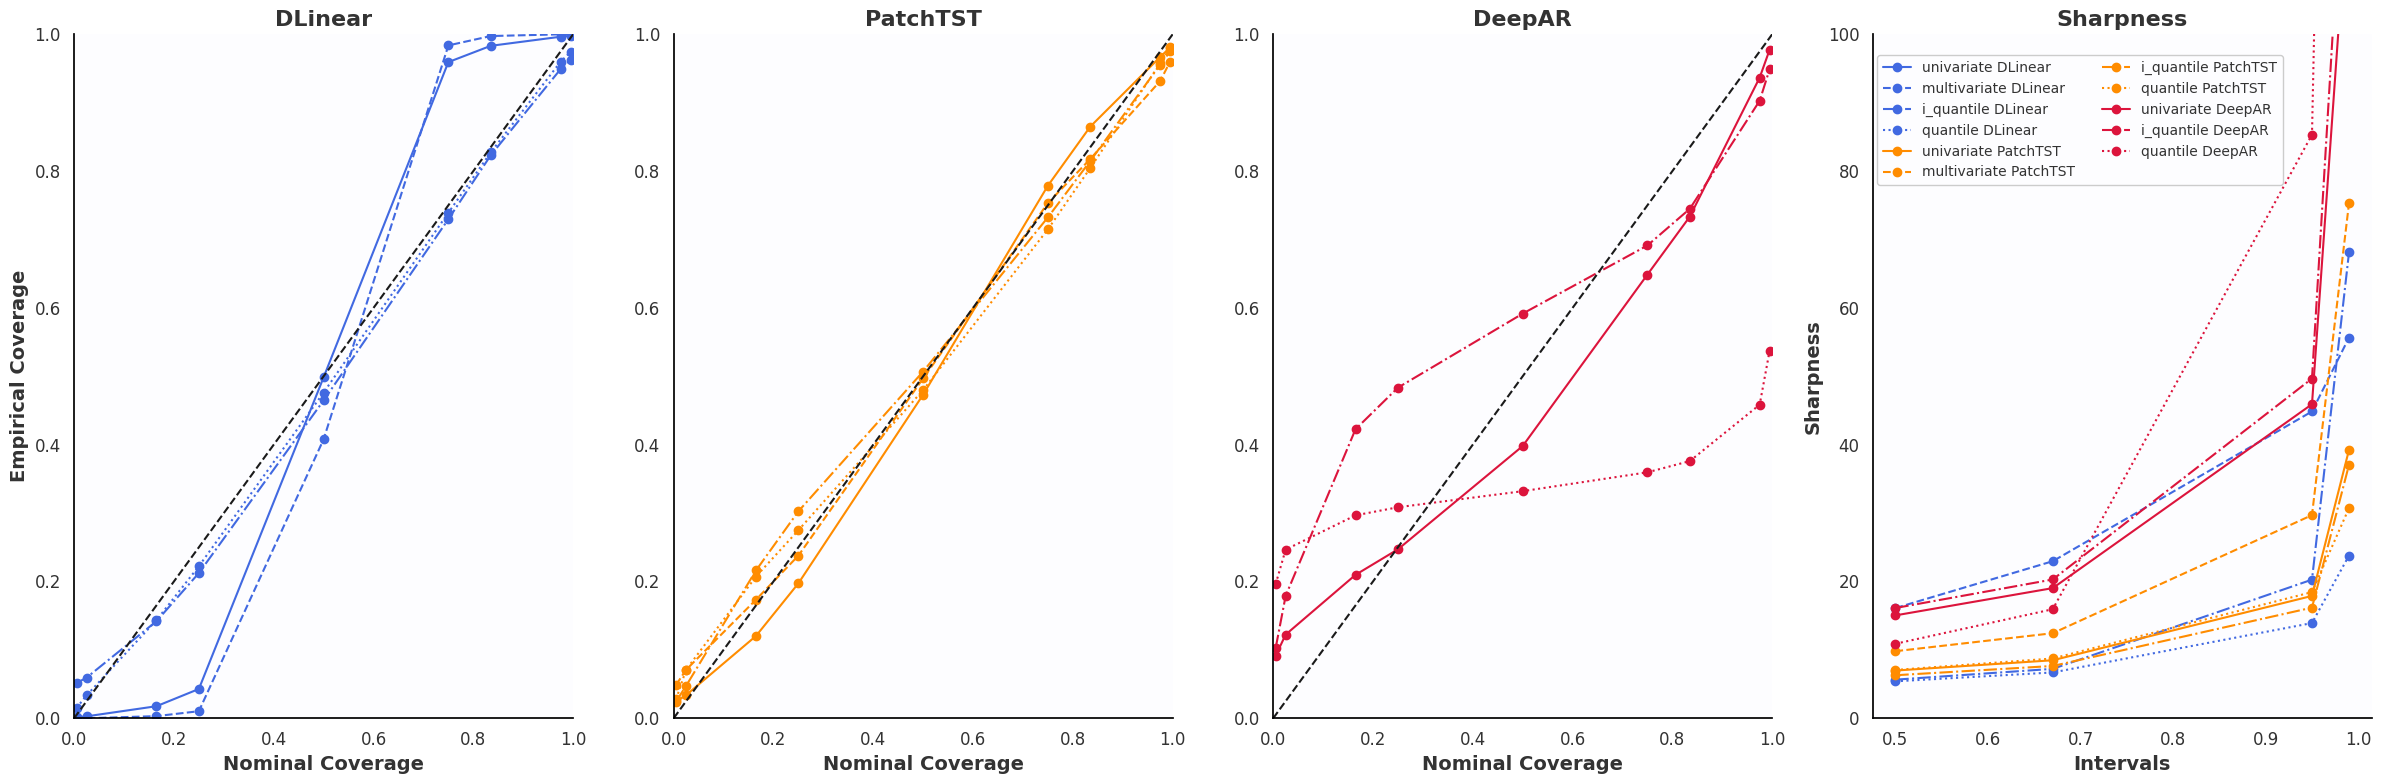

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os

# Quantile levels and sharpness intervals
quantile_levels = [0.005, 0.025, 0.165, 0.25, 0.5, 0.75, 0.835, 0.975, 0.995]
sharpness_intervals = [0.5, 0.67, 0.95, 0.99]

# Style
custom_text_color = "#333333"
custom_bg = "#FDFDFF"
custom_theme = {
    'axes.facecolor': custom_bg,
    'axes.edgecolor': 'black',
    'axes.grid': False,
    'grid.color': '#dcdcdc',
    'xtick.color': custom_text_color,
    'ytick.color': custom_text_color,
    'axes.labelcolor': custom_text_color,
    'text.color': custom_text_color
}
sns.set_theme(style='white')
sns.set_style("white", rc=custom_theme)

# Models and distributions
_models = ['DLinear', 'PatchTST', 'DeepAR']
_dists = ['univariate', 'multivariate', 'i_quantile', 'quantile']
dataset = 'ETTm1'

# Colors and linestyles
colors = {
    'DeepAR': "#DC143C",
    'DLinear': "#4169E1",
    'PatchTST': "#FF8C00",
}
linestyle = {
    'univariate': "-",
    'multivariate': "--",
    'quantile': ":",
    'i_quantile': '-.'
}

# Create subplots: one per model (coverage) + one for sharpness
fig, axs = plt.subplots(ncols=len(_models)+1, figsize=(6 * (len(_models)+1), 8))

# --- Coverage Subplots ---
for idx, model in enumerate(_models):
    ax = axs[idx]
    for dist in _dists:
        prefix='work'
        if model == 'DLinear':
            prefix = 'ceph'
        path = f"/{prefix}/kreffert/Probabilistic_LTSF/BasicTS/final_weights/{dataset}/{model}/{dist}/evaluation.pkl"
        if os.path.isfile(path):
            with open(path, 'rb') as f:
                results = pickle.load(f)
            empirical_coverage = [
                results[f'coverage_{q}']['mean'] for q in quantile_levels
            ]
            ax.plot(quantile_levels, empirical_coverage, marker='o',
                    color=colors[model], linestyle=linestyle[dist], label=dist)

    ax.plot([0, 1], [0, 1], 'k--', label='Ideal')
    ax.set_title(f"{model}", fontsize=16, fontweight='bold')
    ax.set_xlabel("Nominal Coverage", fontsize=14, fontweight='bold')
    if idx == 0:
        ax.set_ylabel("Empirical Coverage", fontsize=14, fontweight='bold')
    ax.tick_params(axis='both', labelsize=12)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)

# --- Sharpness Plot ---
sharp_ax = axs[-1]
for model in _models:
    for dist in _dists:
        prefix='work'
        if model == 'DLinear':
            prefix = 'ceph'
        path = f"/{prefix}/kreffert/Probabilistic_LTSF/BasicTS/final_weights/{dataset}/{model}/{dist}/evaluation.pkl"
        if os.path.isfile(path):
            with open(path, 'rb') as f:
                results = pickle.load(f)
            sharpness = [
                results[f'is_{i}']['mean'] for i in sharpness_intervals
            ]
            sharp_ax.plot(sharpness_intervals, sharpness, marker='o',
                          color=colors[model], linestyle=linestyle[dist], label=f"{dist} {model}")

sharp_ax.set_title("Sharpness", fontsize=16, fontweight='bold')
sharp_ax.set_xlabel("Intervals", fontsize=14, fontweight='bold')
sharp_ax.set_ylabel("Sharpness", fontsize=14, fontweight='bold')
sharp_ax.set_ylim(0, 100)
sharp_ax.tick_params(axis='both', labelsize=12)

# Layout and legend
plt.tight_layout()
sns.despine(left=False, bottom=False)

# Shared legend
handles, labels = axs[-1].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=2, bbox_to_anchor=(0.87, 0.75),
           fontsize=10, frameon=True, framealpha=1)

plt.savefig("/home/kreffert/Probabilistic_LTSF/notebooks/Coverage_and_sharpness_split.pdf",
            format='pdf', dpi=600, bbox_inches='tight')
plt.show()


# evaluation

In [2]:
print(_configs)

{'ETTm1': {'DeepAR': {'iq': {0: {'cfg': 'final_weights/ETTm1/DeepAR/i_quantile/0/3a4f70393b1b6ae6095e27f66999db28/ETTm1_prob_quantile.py', 'ckpt': 'final_weights/ETTm1/DeepAR/i_quantile/0/3a4f70393b1b6ae6095e27f66999db28/DeepAR_best_val_QL.pt'}}, 'q': {0: {'cfg': 'final_weights/ETTm1/DeepAR/quantile/0/f9b1ee3c0b6a85a18d4b72a48c64a31a/ETTm1_prob_quantile.py', 'ckpt': 'final_weights/ETTm1/DeepAR/quantile/0/f9b1ee3c0b6a85a18d4b72a48c64a31a/DeepAR_best_val_QL.pt'}, 1: {'cfg': 'final_weights/ETTm1/DeepAR/quantile/1/58307eba51caf15e5219b9611b686b5c/ETTm1_prob_quantile.py', 'ckpt': 'final_weights/ETTm1/DeepAR/quantile/1/58307eba51caf15e5219b9611b686b5c/DeepAR_best_val_QL.pt'}}}}}


In [4]:
import torch
import pickle
import gc
import torch  # assuming PyTorch is being used
from prob.prob_head import ProbabilisticHead
from basicts.data import TimeSeriesForecastingDataset, OneStepForecastingDataset
import numpy as np

def load_cfg(cfg, random_state=None):
    from easytorch.config import init_cfg
    # cfg path which start with dot will crash the easytorch, just remove dot
    while isinstance(cfg, str) and cfg.startswith(('./','.\\')):
        cfg = cfg[2:]
    # while ckpt_path.startswith(('./','.\\')):
    #     ckpt_path = ckpt_path[2:]
    
    # initialize the configuration
    cfg = init_cfg(cfg, save=False)
    return cfg
    
@torch.no_grad()
def _forward(runner, cfg, data, epoch: int = None, iter_num: int = None, train: bool = False, ims=False, **kwargs):
        """
        Performs the forward pass for training, validation, and testing. 

        Args:
            data (Dict): A dictionary containing 'target' (future data) and 'inputs' (history data) (normalized by self.scaler).
            epoch (int, optional): Current epoch number. Defaults to None.
            iter_num (int, optional): Current iteration number. Defaults to None.
            train (bool, optional): Indicates whether the forward pass is for training. Defaults to True.

        Returns:
            Dict: A dictionary containing the keys:
                  - 'inputs': Selected input features.
                  - 'prediction': Model predictions.
                  - 'target': Selected target features.

        Raises:
            AssertionError: If the shape of the model output does not match [B, L, N].
        """
        distribution_type = runner.distribution_type
        model_name = cfg["MODEL"]["NAME"]
        if distribution_type in ['gaussian', 'student_t', 'laplace', 'm_lr_gaussian']:
             prob_args = cfg['MODEL']['PARAM'].get('prob_args', None)
             prob_head = ProbabilisticHead(1, 1, distribution_type, prob_args=prob_args)
             sample = True
        elif distribution_type in ['i_quantile']:
            sample = True
        else:
            prob_head = None
            sample = False
        data = runner.preprocessing(data)

        # Preprocess input data
        future_data, history_data = data['target'], data['inputs']
        history_data = runner.to_running_device(history_data)  # Shape: [B, L, N, C]
        future_data = runner.to_running_device(future_data)    # Shape: [B, L, N, C]
        batch_size, length, num_nodes, _ = future_data.shape

        # Select input features
        history_data = runner.select_input_features(history_data)
        future_data_4_dec = runner.select_input_features(future_data)

        if not train:
            # For non-training phases, use only temporal features
            future_data_4_dec[..., 0] = torch.empty_like(future_data_4_dec[..., 0])

        # Forward pass through the model
        if not (model_name == 'DeepAR'):# and distribution_type in ['i_quantile']):
            with torch.no_grad():
                runner.model.eval()
                model_return = runner.model(history_data=history_data, future_data=future_data_4_dec,
                                            batch_seen=iter_num, epoch=epoch, train=train)
            if distribution_type in ['gaussian', 'student_t', 'laplace', 'm_lr_gaussian']:
                samples = prob_head.sample(model_return, num_samples=100, random_state=None) # shape torch.Size([num_samples, batch_size, output_len, num_series])
                samples = samples.permute(1, 2, 3, 0)
            elif distribution_type in ['i_quantile']:
                samples = model_return[..., -100:] # torch.Size([64, 720, 7, 100])
                model_return = model_return[..., :-100]
        else:
            with torch.no_grad():
                if distribution_type not in ['i_quantile']:
                    model_return = runner.model(history_data=history_data, future_data=future_data_4_dec,
                                                batch_seen=iter_num, epoch=epoch, train=train) #.sample_trajectories(history_data=history_data, future_data=future_data_4_dec, num_samples=100)
                else:
                    model_return = runner.model.sample_trajectories(history_data=history_data, future_data=future_data_4_dec, num_samples=100).squeeze(-1)
                    model_return = model_return.permute(0, 2, 3, 1)
                    samples = model_return[..., -100:] # torch.Size([64, 720, 7, 100])
                    model_return = model_return[..., :-100]
                # model_return = model_return.permute(1, 2, 3, 0)
                # print(model_return.shape)
                # print(model_return[0, :, 0, :])
                if distribution_type not in ['quantile', 'i_quantile']:
                    samples = runner.model.sample_trajectories(history_data=history_data, future_data=future_data_4_dec, num_samples=100).squeeze(-1)
                    samples = samples.permute(0, 2, 3, 1)
                # model_return = torch.zeros(batch_size, length, num_nodes, 4)
            

        # Parse model return
        if isinstance(model_return, torch.Tensor):
            model_return = {'prediction': model_return}
        if 'inputs' not in model_return:
            model_return['inputs'] = runner.select_target_features(history_data)
        if 'target' not in model_return:
            model_return['target'] = runner.select_target_features(future_data)
            
        # Ensure the output shape is correct
        assert list(model_return['prediction'].shape)[:3] == [batch_size, length, num_nodes], \
            f"The shape of the output is incorrect. Ensure it matches [B, L, N, C]. Current {list(model_return['prediction'].shape)[:3]} != {[batch_size, length, num_nodes]}"

        model_return = runner.postprocessing(model_return)
        if sample:
            model_return['samples'] = runner.scaler.inverse_transform(samples, head='quantile')
            assert list(model_return['samples'].shape)[:3] == [batch_size, length, num_nodes], \
            f"The shape of the output is incorrect. Ensure it matches [B, L, N, C]. Current {list(model_return['samples'].shape)} != {[batch_size, length, num_nodes]}"
        return model_return
            
@torch.no_grad()
def get_predictions(runner, cfg, first_only=False):
    print(cfg["MODEL"]["NAME"])
    # init test
    runner.test_interval = cfg['TEST'].get('INTERVAL', 1)
    runner.test_data_loader = runner.build_test_data_loader(cfg)

    runner.model.eval()
    prediction, target, inputs = [], [], []
    distribution_type = runner.distribution_type
    if distribution_type in ['gaussian', 'student_t', 'laplace', 'm_lr_gaussian', 'i_quantile']:
        sample = True
        samples = []
    else:
        sample = False
    pbar = tqdm(runner.test_data_loader)
    losses = []
    for i, data in enumerate(pbar):
        if (i >= 1) and (first_only):
            break
        # if model DeepAR -> forward with postprocessing of quantile and 100 sample trajectories!
        
        forward_return = _forward(runner, cfg, data, epoch=None, iter_num=None, train=False)
        if not runner.if_evaluate_on_gpu:
            forward_return['prediction'] = forward_return['prediction'].detach().cpu()
            forward_return['target'] = forward_return['target'].detach().cpu()
            forward_return['inputs'] = forward_return['inputs'].detach().cpu()
            if sample:
                forward_return['samples'] = forward_return['samples'].detach().cpu()
        # print(forward_return['prediction'].shape)
        loss = runner.metric_forward(runner.loss, forward_return)
        losses.append(loss)
        pbar.set_postfix(avg_loss=f"{torch.mean(torch.tensor(losses)):.4f}", loss=f"{loss:.4f}")
                

        prediction.append(forward_return['prediction'])
        target.append(forward_return['target'])
        inputs.append(forward_return['inputs'])
        if sample:
            samples.append(forward_return['samples'])

    prediction = torch.cat(prediction, dim=0)
    target = torch.cat(target, dim=0)
    inputs = torch.cat(inputs, dim=0)
    if sample:
        samples = torch.cat(samples, dim=0)
        return {'prediction': prediction, 'target': target, 'inputs': inputs, 'samples':samples}
    else:
        return {'prediction': prediction, 'target': target, 'inputs': inputs}
    # configs[dataset][model][dist][random_state]['returns_all'] = returns_all

def load_runner(configs, first_only=False):
    for dataset in configs.keys():
        for model in configs[dataset].keys():
            for dist in configs[dataset][model].keys():
                for random_state in configs[dataset][model][dist].keys():
                    # configs[dataset][model][dist][random_state]['cfg'] = load_cfg(configs[dataset][model][dist][random_state]['cfg'])
                    # cfg = configs[dataset][model][dist][random_state]['cfg']
                    cfg = load_cfg(configs[dataset][model][dist][random_state]['cfg'])
                    cfg['DATASET']['TYPE'] = TimeSeriesForecastingDataset
                    prefix = '/work/kreffert'
                    ckpt = configs[dataset][model][dist][random_state]['ckpt']
                    
                    ckpt_dir = cfg['TRAIN'].get('CKPT_SAVE_DIR', None)
                    ckpt_dir = ckpt_dir.replace("/home", "/work")
                    if False: #os.path.isfile(f"{ckpt_dir}/model_return.pkl"):
                        print(f'Model return already available {ckpt_dir}/model_return.pkl')
                    else:
                        strict=True
                        runner = cfg['RUNNER'](cfg)
                        # setup the graph if needed
                        if runner.need_setup_graph:
                            runner.setup_graph(cfg=cfg, train=False)
                            
                        print(f'Loading model checkpoint from {ckpt}')
                        runner.load_model(ckpt_path=ckpt, strict=strict)
                        
                        # runner.test_pipeline(cfg=cfg, save_metrics=False, save_results=False)
                        # configs[dataset][model][dist][random_state]['runner'] = runner
    
                        # produce predictions
                        returns_all = get_predictions(runner, cfg, first_only=first_only)
                        print(returns_all['prediction'].shape)
                        print(returns_all['target'].shape)
                        print(returns_all['inputs'].shape)
                        if 'samples' in returns_all.keys():
                            print(returns_all['samples'].shape)

                        # save the input and target one time individually, if they have not been saved yet
                        if not os.path.isfile(f"/work/kreffert/Probabilistic_LTSF/BasicTS/final_weights/{dataset}/inputs.pkl"):
                            with open(f'/work/kreffert/Probabilistic_LTSF/BasicTS/final_weights/{dataset}/inputs.pkl', 'wb') as f:
                                pickle.dump(returns_all['inputs'], f)
                        if not os.path.isfile(f"/work/kreffert/Probabilistic_LTSF/BasicTS/final_weights/{dataset}/target.pkl"):
                            with open(f'/work/kreffert/Probabilistic_LTSF/BasicTS/final_weights/{dataset}/target.pkl', 'wb') as f:
                                pickle.dump(returns_all['target'], f)
                            
                        # Save predictions and samples together in one dict
                        results_dict = {"prediction": returns_all["prediction"]}
                        
                        if "samples" in returns_all:
                            results_dict["samples"] = returns_all["samples"]
                        
                        ckpt_dir = cfg['TRAIN'].get('CKPT_SAVE_DIR', None)
                        ckpt_dir = ckpt_dir.replace("/home", "/work")
                        os.makedirs(ckpt_dir, exist_ok=True)
                        print(f'saved under {ckpt_dir}/model_return.pkl')
                        with open(f'{ckpt_dir}/model_return.pkl', 'wb') as f:
                            pickle.dump(results_dict, f)
                        del runner
                        del cfg
                        del returns_all
                        gc.collect()
                        torch.cuda.empty_cache()

# deepar = {'ETTh1': {'DeepAR': {'u': {2: {'cfg': 'final_weights/ETTh1/DeepAR/univariate/2/61d4606f2ce85d01757a4e462bf0517c/ETTh1_prob.py', 'ckpt': 'final_weights/ETTh1/DeepAR/univariate/2/61d4606f2ce85d01757a4e462bf0517c/DeepAR_best_val_NLL.pt'}}}}}
# deepar = {'ETTh1': {'DLinear': {'iq': {2: {'cfg': 'final_weights/ETTh1/DLinear/i_quantile/2/7e59031295d7db4c807d3b5f9db7bc80/ETTh1_prob_quantile.py', 'ckpt': 'final_weights/ETTh1/DLinear/i_quantile/2/7e59031295d7db4c807d3b5f9db7bc80/DLinear_best_val_QL.pt'}}}}}
# deepar = {'ETTh1': {'PatchTST': {'iq': {0: {'cfg': 'final_weights/ETTh1/PatchTST/i_quantile/0/18e94527d1a5fb49c065e3d1f706cfbf/ETTh1_prob_quantile.py', 'ckpt': 'final_weights/ETTh1/PatchTST/i_quantile/0/18e94527d1a5fb49c065e3d1f706cfbf/PatchTST_best_val_QL.pt'}}}}}
# deepar = {'ETTh1': {'DeepAR': {'iq': {2: {'cfg': 'final_weights/ETTh1/DeepAR/i_quantile/2/10b4108b626a9d27fad40eddcff3715a/ETTh1_prob_quantile.py', 'ckpt': 'final_weights/ETTh1/DeepAR/i_quantile/2/10b4108b626a9d27fad40eddcff3715a/DeepAR_best_val_QL.pt'}}}}}
# deepar = {'ETTh1': {'DLinear': {'q': {2: {'cfg': 'final_weights/ETTh1/DLinear/quantile/2/a7f10e8c211a68a5aeb51fbaec3c28a5/ETTh1_prob_quantile.py', 'ckpt': 'final_weights/ETTh1/DLinear/quantile/2/a7f10e8c211a68a5aeb51fbaec3c28a5/DLinear_best_val_QL.pt'}}}}}
# deepar = {'ETTh1': {'DeepAR': {'q': {2: {'cfg': 'final_weights/ETTh1/DeepAR/quantile/2/2ad27c696897fc216064f719a8bea178/ETTh1_prob_quantile.py', 'ckpt': 'final_weights/ETTh1/DeepAR/quantile/2/2ad27c696897fc216064f719a8bea178/DeepAR_best_val_QL.pt'}}}}}
deepar = {'ETTh1': {#'PatchTST':{#'u': {0: {'cfg': 'final_weights/ETTh1/PatchTST/univariate/0/33a25d8bd030e70363126b5d37ff330c/ETTh1_prob.py', 'ckpt': 'final_weights/ETTh1/PatchTST/univariate/0/33a25d8bd030e70363126b5d37ff330c/PatchTST_best_val_NLL.pt'}}},
                                # 'iq': {0: {'cfg': 'final_weights/ETTh1/PatchTST/i_quantile/fixed/0/ba70dd895b3eb5fe46e2b72d91191a19/ETTh1_prob_quantile.py', 'ckpt': 'final_weights/ETTh1/PatchTST/i_quantile/fixed/0/ba70dd895b3eb5fe46e2b72d91191a19/PatchTST_best_val_QL.pt'}}},
                    #'PatchTSTg':{'u': {0: {'cfg': 'final_weights/ETTh1/PatchTST/univariate/gaussian/0/bbd74d0064f7f5317b51a6b86ff0f77c/ETTh1_prob.py', 'ckpt': 'final_weights/ETTh1/PatchTST/univariate/gaussian/0/bbd74d0064f7f5317b51a6b86ff0f77c/PatchTST_best_val_NLL.pt'}},
                    # 'DeepAR': {'u': {0: {'cfg': 'final_weights/ETTh1/DeepAR/univariate/0/f7d0a9c9a4f592c7d2597ea802b6e624/ETTh1_prob.py', 'ckpt': 'final_weights/ETTh1/DeepAR/univariate/0/f7d0a9c9a4f592c7d2597ea802b6e624/DeepAR_best_val_NLL.pt'}}},
                    'DeepARg': {#'u': {0: {'cfg': 'final_weights/ETTh1/DeepAR/univariate/gaussian/0/15228193146f993b3a04d1c5d6d3a1df/ETTh1_prob.py', 'ckpt': 'final_weights/ETTh1/DeepAR/univariate/gaussian/0/15228193146f993b3a04d1c5d6d3a1df/DeepAR_best_val_NLL.pt'}},
                               #'q': {0: {'cfg': 'final_weights/ETTh1/DeepAR/quantile/0/32013b30d97a3849dafb8295ede9d057/ETTh1_prob_quantile.py', 'ckpt': 'final_weights/ETTh1/DeepAR/quantile/0/32013b30d97a3849dafb8295ede9d057/DeepAR_best_val_QL.pt'}},
                                'iq': {0: {'cfg': 'final_weights/ETTh1/DeepAR/i_quantile/0/9579ddec2d6dfa935fc302c839d3a6f5/ETTh1_prob_quantile.py', 'ckpt': 'final_weights/ETTh1/DeepAR/i_quantile/0/9579ddec2d6dfa935fc302c839d3a6f5/DeepAR_best_val_QL.pt'}}},
                    # 'DLinear': {'u': {0: {'cfg': 'final_weights/ETTh1/DLinear/univariate/0/22c6c387919d63a0b8c3899c830017fe/ETTh1_prob.py', 'ckpt': 'final_weights/ETTh1/DLinear/univariate/0/22c6c387919d63a0b8c3899c830017fe/DLinear_best_val_NLL.pt'}}}
                   }}
load_runner(_configs, first_only=True)
# load_runner(_configs) #_configs)

2025-07-09 08:24:05,677 - easytorch-env - INFO - Disable TF32 mode
2025-07-09 08:24:05,680 - easytorch-env - INFO - Use deterministic algorithms.
2025-07-09 08:24:05,680 - easytorch-env - INFO - Set cudnn deterministic.
2025-07-09 08:24:05,680 - easytorch - INFO - Set ckpt save dir: '/home/kreffert/Probabilistic_LTSF/BasicTS/final_weights/ETTm1/DeepAR/i_quantile/0/3a4f70393b1b6ae6095e27f66999db28'
2025-07-09 08:24:05,681 - easytorch - INFO - Building model.
2025-07-09 08:24:06,021 - easytorch - INFO - Load model from : final_weights/ETTm1/DeepAR/i_quantile/0/3a4f70393b1b6ae6095e27f66999db28/DeepAR_best_val_QL.pt
2025-07-09 08:24:06,021 - easytorch - INFO - Loading Checkpoint from 'final_weights/ETTm1/DeepAR/i_quantile/0/3a4f70393b1b6ae6095e27f66999db28/DeepAR_best_val_QL.pt'
2025-07-09 08:24:06,033 - easytorch - INFO - Test dataset length: 10705


DeepAR
Loading model checkpoint from final_weights/ETTm1/DeepAR/i_quantile/0/3a4f70393b1b6ae6095e27f66999db28/DeepAR_best_val_QL.pt
DeepAR


  0%|▍                                                                                                                             | 1/335 [01:13<6:47:41, 73.24s/it, avg_loss=1.3741, loss=1.3741]


torch.Size([32, 720, 7, 9])
torch.Size([32, 720, 7, 1])
torch.Size([32, 96, 7, 1])
torch.Size([32, 720, 7, 100])
saved under /work/kreffert/Probabilistic_LTSF/BasicTS/final_weights/ETTm1/DeepAR/i_quantile/0/model_return.pkl


2025-07-09 08:25:19,525 - easytorch-env - INFO - Disable TF32 mode
2025-07-09 08:25:19,527 - easytorch-env - INFO - Use deterministic algorithms.
2025-07-09 08:25:19,527 - easytorch-env - INFO - Set cudnn deterministic.
2025-07-09 08:25:19,527 - easytorch - INFO - Set ckpt save dir: '/home/kreffert/Probabilistic_LTSF/BasicTS/final_weights/ETTm1/DeepAR/quantile/0/f9b1ee3c0b6a85a18d4b72a48c64a31a'
2025-07-09 08:25:19,528 - easytorch - INFO - Building model.
2025-07-09 08:25:19,537 - easytorch - INFO - Load model from : final_weights/ETTm1/DeepAR/quantile/0/f9b1ee3c0b6a85a18d4b72a48c64a31a/DeepAR_best_val_QL.pt
2025-07-09 08:25:19,538 - easytorch - INFO - Loading Checkpoint from 'final_weights/ETTm1/DeepAR/quantile/0/f9b1ee3c0b6a85a18d4b72a48c64a31a/DeepAR_best_val_QL.pt'
2025-07-09 08:25:19,556 - easytorch - INFO - Test dataset length: 10705


DeepAR
Loading model checkpoint from final_weights/ETTm1/DeepAR/quantile/0/f9b1ee3c0b6a85a18d4b72a48c64a31a/DeepAR_best_val_QL.pt
DeepAR


  0%|▍                                                                                                                               | 1/335 [00:00<05:10,  1.07it/s, avg_loss=1.2901, loss=1.2901]
2025-07-09 08:25:20,650 - easytorch-env - INFO - Disable TF32 mode
2025-07-09 08:25:20,651 - easytorch-env - INFO - Use deterministic algorithms.
2025-07-09 08:25:20,651 - easytorch-env - INFO - Set cudnn deterministic.
2025-07-09 08:25:20,652 - easytorch - INFO - Set ckpt save dir: '/home/kreffert/Probabilistic_LTSF/BasicTS/final_weights/ETTm1/DeepAR/quantile/1/58307eba51caf15e5219b9611b686b5c'
2025-07-09 08:25:20,652 - easytorch - INFO - Building model.
2025-07-09 08:25:20,661 - easytorch - INFO - Load model from : final_weights/ETTm1/DeepAR/quantile/1/58307eba51caf15e5219b9611b686b5c/DeepAR_best_val_QL.pt
2025-07-09 08:25:20,662 - easytorch - INFO - Loading Checkpoint from 'final_weights/ETTm1/DeepAR/quantile/1/58307eba51caf15e5219b9611b686b5c/DeepAR_best_val_QL.pt'


torch.Size([32, 720, 7, 9])
torch.Size([32, 720, 7, 1])
torch.Size([32, 96, 7, 1])
saved under /work/kreffert/Probabilistic_LTSF/BasicTS/final_weights/ETTm1/DeepAR/quantile/0/model_return.pkl
DeepAR
Loading model checkpoint from final_weights/ETTm1/DeepAR/quantile/1/58307eba51caf15e5219b9611b686b5c/DeepAR_best_val_QL.pt


2025-07-09 08:25:20,691 - easytorch - INFO - Test dataset length: 10705


DeepAR


  0%|▍                                                                                                                               | 1/335 [00:00<05:10,  1.08it/s, avg_loss=1.2790, loss=1.2790]

torch.Size([32, 720, 7, 9])
torch.Size([32, 720, 7, 1])
torch.Size([32, 96, 7, 1])
saved under /work/kreffert/Probabilistic_LTSF/BasicTS/final_weights/ETTm1/DeepAR/quantile/1/model_return.pkl


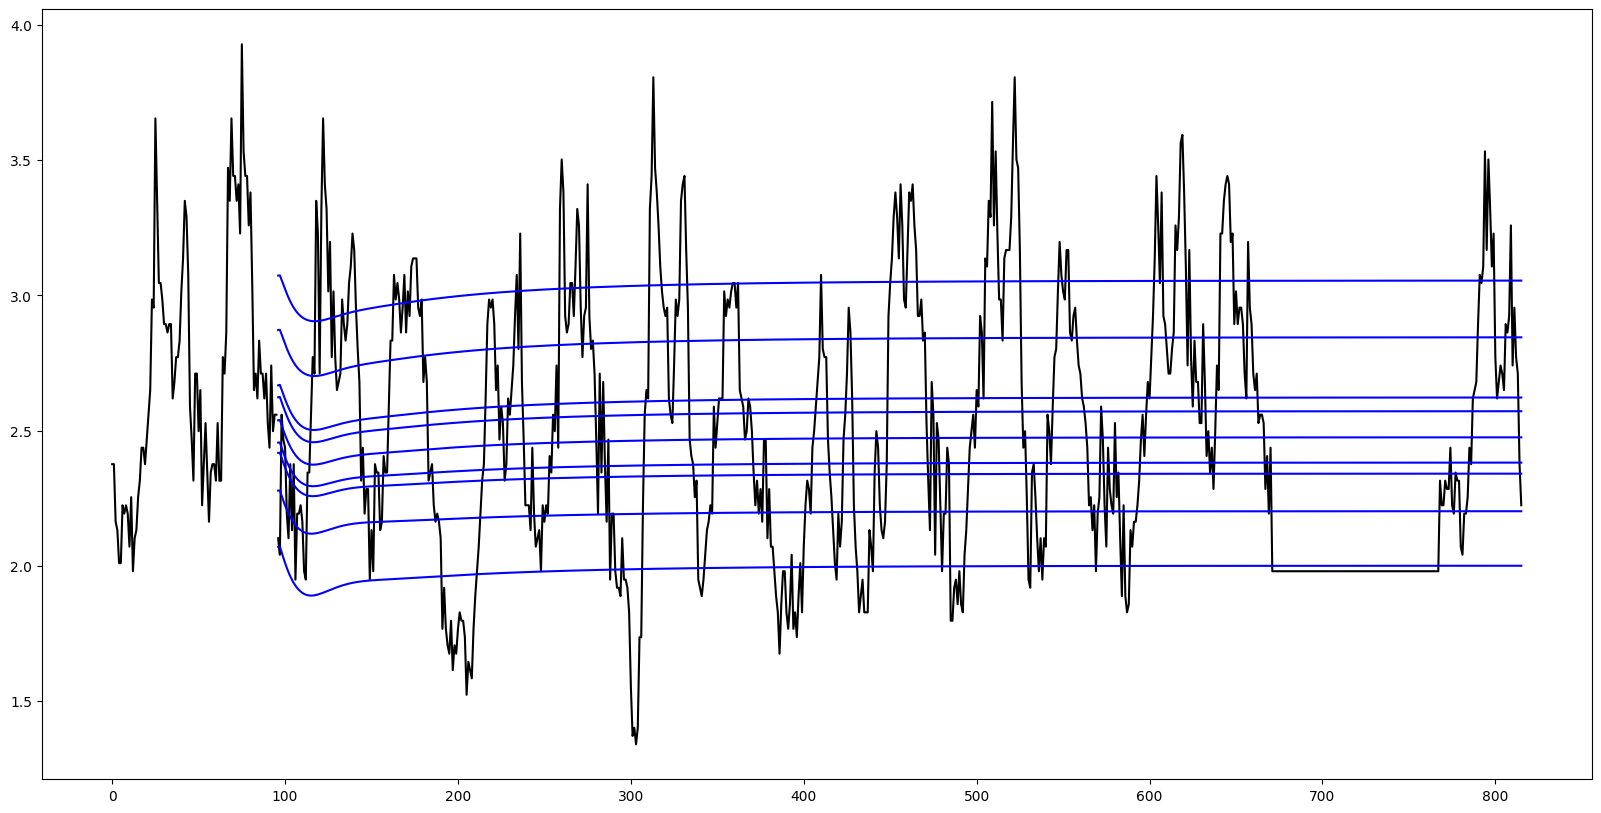

In [8]:
# analyze individual model
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pickle
import torch
# path = f"/work/kreffert/Probabilistic_LTSF/BasicTS/final_weights/ETTh1/DeepAR/univariate/gaussian/1/model_return.pkl"
path = f"/work/kreffert/Probabilistic_LTSF/BasicTS/final_weights/ETTm1/DeepAR/quantile/1/model_return.pkl"


with open(f'/work/kreffert/Probabilistic_LTSF/BasicTS/final_weights/ETTm1/inputs.pkl', 'rb') as f:
    inputs = pickle.load(f)
with open(f'/work/kreffert/Probabilistic_LTSF/BasicTS/final_weights/ETTm1/target.pkl', 'rb') as f:
    target = pickle.load(f)

    
batch_idx = 0
series_idx = 4
plot_samples = False
if os.path.isfile(path):
    with open(path, 'rb') as f:
        model_return = pickle.load(f)
    _inputs = inputs[batch_idx, :, series_idx, :].to('cpu')
    _target = target[batch_idx, :, series_idx, :].to('cpu')
    time = np.arange(_inputs.shape[0], _inputs.shape[0] + _target.shape[0])
    plt.figure(figsize=(20, 10))
    plt.plot(np.arange(_inputs.shape[0]), _inputs, color="black")
    plt.plot(time, _target, color="black")
    if plot_samples:
        samples = model_return['samples'][batch_idx, :, series_idx, :].to('cpu')
        median = torch.median(samples, dim=1).values
        plt.plot(time, median, color="blue") 
        for i in range(20):#samples.shape[-1]):
            plt.plot(time, samples[:, i], color="blue", alpha=0.3) 
    else:
        predictions = model_return['prediction'][batch_idx, :, series_idx, :].to('cpu')
        for i in range(predictions.shape[-1]):
           plt.plot(time, predictions[:, i], color="blue") 
else:
    print(path)
plt.show()

/tmp/ipykernel_666621/2067599101.py:53: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_min, y_max = np.min(np.array(target)), np.max(np.array(target))
  0%|                                                                                                                                                                        | 0/3 [00:00<?, ?it/s]

/work/kreffert/Probabilistic_LTSF/BasicTS/final_weights/ETTm1/DLinear/univariate/0/model_return.pkl
/work/kreffert/Probabilistic_LTSF/BasicTS/final_weights/ETTm1/DLinear/multivariate/0/model_return.pkl
/work/kreffert/Probabilistic_LTSF/BasicTS/final_weights/ETTm1/DLinear/i_quantile/0/model_return.pkl
/work/kreffert/Probabilistic_LTSF/BasicTS/final_weights/ETTm1/DLinear/quantile/0/model_return.pkl
/work/kreffert/Probabilistic_LTSF/BasicTS/final_weights/ETTm1/PatchTST/univariate/0/model_return.pkl
/work/kreffert/Probabilistic_LTSF/BasicTS/final_weights/ETTm1/PatchTST/multivariate/0/model_return.pkl
/work/kreffert/Probabilistic_LTSF/BasicTS/final_weights/ETTm1/PatchTST/i_quantile/0/model_return.pkl
/work/kreffert/Probabilistic_LTSF/BasicTS/final_weights/ETTm1/PatchTST/quantile/0/model_return.pkl
/work/kreffert/Probabilistic_LTSF/BasicTS/final_weights/ETTm1/DeepAR/multivariate/0/model_return.pkl
/work/kreffert/Probabilistic_LTSF/BasicTS/final_weights/ETTm1/DeepAR/i_quantile/0/model_return.

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:26<00:00,  8.67s/it]


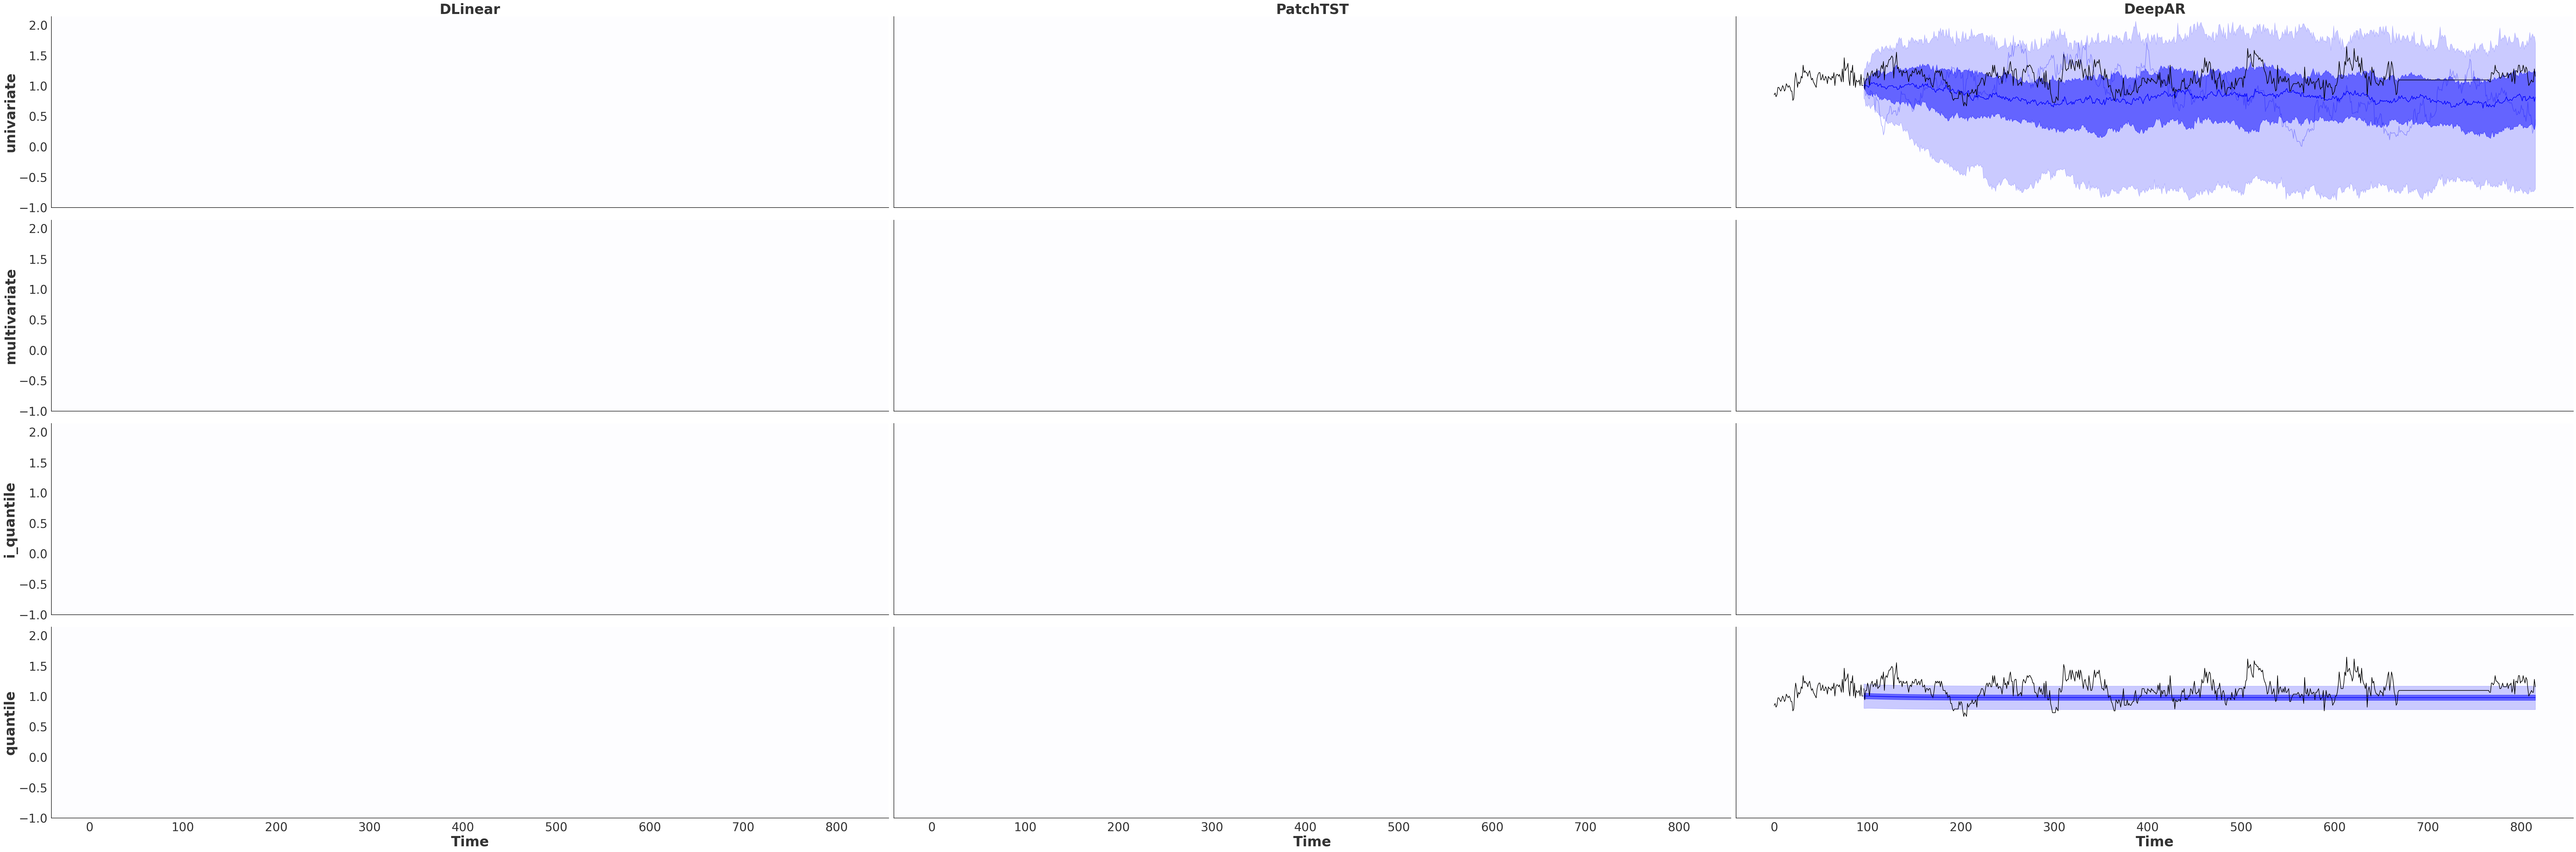

In [4]:
import seaborn as sns
import pickle
import torch
def create_plot(ax, model_return, distribution_type, inputs, target, num_samples=0, batch_idx=0, series_idx=0):
    quantile_levels = [0.005, 0.025, 0.165, 0.25, 0.5, 0.75, 0.835, 0.975, 0.995]
    # first plot the ground truth
    time = np.arange(inputs.shape[0], inputs.shape[0] + target.shape[0])
    ax.plot(np.arange(inputs.shape[0]), inputs, color="black")
    ax.plot(time, target, color="black")
    if distribution_type == 'quantile':
        predictions = model_return['prediction'][batch_idx, :, series_idx, :].to('cpu')
        q_025 = predictions[:, quantile_levels.index(0.25)]
        q_075 = predictions[:, quantile_levels.index(0.75)]
        q_0025 = predictions[:, quantile_levels.index(0.025)]
        q_0975 = predictions[:, quantile_levels.index(0.975)]
        median = predictions[:, quantile_levels.index(0.5)] 
    else:
        samples = model_return['samples'][batch_idx, :, series_idx, :].to('cpu')
        q_025 = torch.quantile(samples, 0.25, dim=1)
        q_075 = torch.quantile(samples, 0.75, dim=1)
        q_0025 = torch.quantile(samples, 0.025, dim=1)
        q_0975 = torch.quantile(samples, 0.975, dim=1)
        median = torch.median(samples, dim=1).values
        if num_samples>0:
            for i in range(num_samples):
                if i==0:
                    ax.plot(time, samples[:, i], color='blue', alpha=0.3, label='sample')
                else:
                    ax.plot(time, samples[:, i], color='blue', alpha=0.3)
            
    # Plot
    ax.plot(time, median, color='blue', label='median')
    ax.fill_between(time, q_025, q_075, color='blue', alpha=0.5, label='50% interval')
    ax.fill_between(time, q_0025, q_0975, color='blue', alpha=0.2, label='90% interval')

import matplotlib.pyplot as plt
import numpy as np
_datasets=['ETTm1']#, 'ETTm1']
_models=['DLinear', 'PatchTST', 'DeepAR'] # 'PatchTSTg']
_dists=['univariate', 'multivariate', 'i_quantile', 'quantile']
# _dists = ['i_quantile', 'quantile'] 
# _dists = ['quantile']
_seeds=[0]
with open(f'/work/kreffert/Probabilistic_LTSF/BasicTS/final_weights/ETTm1/inputs.pkl', 'rb') as f:
    inputs = pickle.load(f)
with open(f'/work/kreffert/Probabilistic_LTSF/BasicTS/final_weights/ETTm1/target.pkl', 'rb') as f:
    target = pickle.load(f)
batch_idx = 2
series_idx = 0
for series_idx in [5]:
    inputs = inputs[batch_idx, :, series_idx, :].to('cpu')
    target = target[batch_idx, :, series_idx, :].to('cpu')
    y_min, y_max = np.min(np.array(target)), np.max(np.array(target))
    custom_text_color = "#333333"
    custom_bg = "#FDFDFF"
    
    custom_theme = {
        'axes.facecolor': custom_bg,
        'axes.edgecolor': 'black',
        'axes.grid': False,
        'grid.color': '#dcdcdc',
        'grid.linestyle': '-',
        'xtick.color': custom_text_color,
        'ytick.color': custom_text_color,
        'axes.labelcolor': custom_text_color,
        'text.color': custom_text_color
    }
    sns.set_theme(style='white')
    sns.set_style("white", rc=custom_theme)
    fig, axs = plt.subplots(nrows=len(_dists), ncols=len(_models), figsize=(90, 30), sharey=True, sharex=True)
    
    for i in range(len(_models)):
        axs[0][i].set_title(_models[i], fontsize=35, fontweight='bold')
        
    for i in range(len(_dists)):
        axs[i][0].set_ylabel(_dists[i], fontsize=35, fontweight='bold')

    for row in axs:
        for ax in row:
            ax.set_ylim(-1, y_max*1.3)
            ax.tick_params(axis='both', which='major', labelsize=30)
            
    for i, row in enumerate(axs):
        if i == len(_dists)-1:
            for ax in row:
                ax.set_xlabel('Time', fontsize=35, fontweight='bold')
    
    plot_samples = True
    for dataset in _datasets:
        for model in tqdm(_models):
            for dist in _dists:
                random_state = 0
                
                path = f"/work/kreffert/Probabilistic_LTSF/BasicTS/final_weights/{dataset}/{model}/{dist}/{random_state}/model_return.pkl"
                # if dist == 'univariate':
                #     if model in ['PatchTST', 'DeepAR']:
                #         path = f"/work/kreffert/Probabilistic_LTSF/BasicTS/final_weights/{dataset}/{model}/{dist}/gaussian/{random_state}/model_return.pkl"
                # if dist == 'i_quantile':
                #     if model in ['PatchTST']: #, 'DeepAR']:
                #         path = f"/work/kreffert/Probabilistic_LTSF/BasicTS/final_weights/{dataset}/{model}/{dist}/fixed/{random_state}/model_return.pkl"
                
                if os.path.isfile(path):
                    with open(path, 'rb') as f:
                        model_return = pickle.load(f)
                    # tqdm.write(f"Loaded {dataset}/{model}/{dist}/{random_state}")
                        
                    # plt.ylim(-20, 20)
                    ax = axs[_dists.index(dist)][_models.index(model)]
                    create_plot(ax, model_return, dist, inputs, target, num_samples=1, batch_idx=batch_idx, series_idx=series_idx)
                    # create_plot_samples(ax, model_return, dist, inputs, target, num_samples=10, batch_idx=batch_idx, series_idx=series_idx)
                    # plt.legend()
                    # plt.title(f"{dataset} - {model} - {dist}")
                else:
                    print(path)
    # plt.xlabel('Time')
    # fig.suptitle(f"{dataset} - Series {dim}", fontsize=18, fontweight='bold')
    plt.tight_layout()
    sns.despine(left=False, bottom=False)
    
    # Create a single legend for the entire figure
    # Collect handles and labels from the last subplot (they should be consistent across all subplots)
    # Collect legend handles from one axis (e.g., the last one)
    handles, labels = axs[0][0].get_legend_handles_labels()
    
    # Create a single shared legend
    # fig.legend(handles, labels, loc='upper center', fontsize=30, ncol=3, frameon=False)
    axs[1][-1].legend(handles, labels, loc='upper left', fontsize=30, frameon=False)
    prefix = "/home/kreffert/"
    # plt.savefig(f"{prefix}Probabilistic_LTSF/notebooks/Final plots/originals_samples.pdf", format='pdf', dpi=1200, bbox_inches='tight')
    plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
_datasets=['ETTh1', 'ETTm1']
_models=['DLinear', 'PatchTST', 'DeepAR', 'PatchTSTg']
# _dists=['univariate', 'multivariate', 'i_quantile']
_dists = ['i_quantile',]# 'i_quantile'] 
_dists = ['quantile']
_seeds=[0]

from prob.prob_head import ProbabilisticHead 
prob_head = ProbabilisticHead(1, 1, 'gaussian', prob_args={})

batch_idx = 2
series_idx = 0
for series_idx in [0]:
    plot_samples = True
    for dataset in _datasets:
        for model in _models:
            for dist in _dists:
                random_state = 0
                if model == 'PatchTSTg':
                    path = f"/work/kreffert/Probabilistic_LTSF/BasicTS/final_weights/{dataset}/PatchTST/{dist}/gaussian/{random_state}/model_return.pkl"
                else:
                    path = f"/work/kreffert/Probabilistic_LTSF/BasicTS/final_weights/{dataset}/{model}/{dist}/{random_state}/model_return.pkl"
                
                if os.path.isfile(path):
                    with open(path, 'rb') as f:
                        model_return = pickle.load(f)
                    # tqdm.write(f"Loaded {dataset}/{model}/{dist}/{random_state}")
                        
                    plt.figure(figsize=(30, 10))
                    # plt.ylim(-20, 20)
                    inputs = model_return['inputs'][batch_idx, :, series_idx, :].to('cpu')
                    target = model_return['target'][batch_idx, :, series_idx, :].to('cpu')
                    time = np.arange(inputs.shape[0], inputs.shape[0] + target.shape[0])
                    plt.plot(np.arange(inputs.shape[0]), inputs, color="orange")
                    plt.plot(time, target, color="orange")
                    if plot_samples:
                        samples = model_return['samples'][batch_idx, :, series_idx, :].to('cpu')
                        # samples = prob_head.sample(model_return['prediction'][batch_idx, :, series_idx, :].to('cpu'), num_samples=100, random_state=None)
                        # samples = samples.permute(1, 0)
                        lower = torch.quantile(samples, 0.25, dim=1)
                        upper = torch.quantile(samples, 0.75, dim=1)
                        median = torch.median(samples, dim=1).values
                        
                        # Plot
                        plt.plot(time, median, color='black', label='median')
                        plt.fill_between(time, lower, upper, color='black', alpha=0.2, label='50% interval')
                        for i in range(5):#samples.shape[-1]):
                            plt.plot(time, samples[:, i], color='blue', alpha=0.2)
                    else:
                        prediction = model_return['prediction'][batch_idx, :, series_idx, :].to('cpu')
                        plt.plot(time, prediction[:, 0], color='blue', alpha=1, label='mean')
                        plt.plot(time, prediction[:, 1], color='blue', alpha=0.2, label='std')
                        plt.fill_between(time, prediction[:, 0] - prediction[:, 1], prediction[:, 0] + prediction[:, 1], color='blue', alpha=0.2, label='±1 std')
                        if prediction.shape[-1]>2:
                            plt.plot(time, prediction[:, 2], color='blue', alpha=0.4, label='df')
                        plt.legend()
                    plt.title(f"{dataset} - {model} - {dist}")
                    plt.show()
                else:
                    print(path)

In [ ]:
dataset = 'ETTh1'
model = 'PatchTST'
dist = 'i_quantile'
random_state = 0
path = f"/work/kreffert/Probabilistic_LTSF/BasicTS/final_weights/{dataset}/{model}/{dist}/{random_state}/model_return.pkl"
if os.path.isfile(path):
    with open(path, 'rb') as f:
        model_return = pickle.load(f)
    print(model_return['samples'].shape)
    print(model_return['samples'][0, :, 0, 4])
    for i in range(5):
        plt.plot()

# old code

In [ ]:
import torch
@torch.no_grad()
def get_predictions(configs):
    for dataset in configs.keys():
        for model in configs[dataset].keys():
            for dist in configs[dataset][model].keys():
                for random_state in configs[dataset][model][dist].keys():
                    runner = configs[dataset][model][dist][random_state]['runner']
                    cfg = configs[dataset][model][dist][random_state]['cfg']
                    # init test
                    runner.test_interval = cfg['TEST'].get('INTERVAL', 1)
                    runner.test_data_loader = runner.build_test_data_loader(cfg)
                
                    runner.model.eval()
                    prediction, target, inputs = [], [], []
                
                    for data in tqdm(runner.test_data_loader):
                        # if model DeepAR -> forward with postprocessing of quantile and 100 sample trajectories!
                        
                        forward_return = runner.forward(data, epoch=None, iter_num=None, train=False)
                        if not runner.if_evaluate_on_gpu:
                            forward_return['prediction'] = forward_return['prediction'].detach().cpu()
                            forward_return['target'] = forward_return['target'].detach().cpu()
                            forward_return['inputs'] = forward_return['inputs'].detach().cpu()
                
                        prediction.append(forward_return['prediction'])
                        target.append(forward_return['target'])
                        inputs.append(forward_return['inputs'])
                
                    prediction = torch.cat(prediction, dim=0)
                    target = torch.cat(target, dim=0)
                    inputs = torch.cat(inputs, dim=0)
                
                    returns_all = {'prediction': prediction, 'target': target, 'inputs': inputs}
                    configs[dataset][model][dist][random_state]['returns_all'] = returns_all
    return configs

_configs = get_predictions(_configs)

In [ ]:
# 1. load the model and set the device
_configs = {'ETTh1_PTST_u': {'cfg':'final_weights/PatchTST/univariate/ETTh1_prob.py',
                           'ckpt': 'final_weights/PatchTST/univariate/ETTh1_100_96_720/a8de06edad7530010e0b704422b431a2/PatchTST_best_val_NLL.pt'
                          },
           # 'ETTh1_PTST_q': {'cfg': 'final_weights/PatchTST/quantile/ETTh1_prob.py',
           #                  'ckpt': 'final_weights/PatchTST/quantile/ETTh1_100_96_720/a2a39ac1680165e5ffbda2c7bbda5add/PatchTST_best_val_QL.pt'
           #                 }
          }

random_states = range(5)

configs = {rs:_configs for rs in random_states}

configs = load_runner(configs, random_states=random_states)
configs = get_predictions(configs)
# metrics_results = self.compute_evaluation_metrics(returns_all)

In [ ]:
import torch
def vs_ensemble_torch(obs, fct, p=1.0):
    """
    Compute Variogram Score using PyTorch on GPU.
    obs: shape (..., D)
    fct: shape (..., M, D)
    """
    M = fct.shape[-2]

    # Compute ensemble variogram component
    fct_diff = fct.unsqueeze(-2) - fct.unsqueeze(-1)  # (B, M, D, D)
    # print(fct_diff.shape)
    vfct = (fct_diff.abs() ** p).sum(dim=-3) / M  # (B, D, D)
    # print(vfct.shape)
    # Compute observed variogram component
    obs_diff = obs.unsqueeze(-2) - obs.unsqueeze(-1)  # (B, D, D)
    vobs = (obs_diff.abs() ** p)  # (B, D, D)
    # print(vobs.shape)
    # print(vfct.shape)
    vs = ((vfct - vobs) ** 2).sum(dim=(-2, -1))  # (B,)
    return vs

def es_ensemble_torch(obs: torch.Tensor, fct: torch.Tensor) -> torch.Tensor:
    """
    Compute the energy score using PyTorch.
    
    Parameters:
    - obs: Tensor of shape (B, D)
    - fct: Tensor of shape (B, M, D)

    Returns:
    - Tensor of shape (B,) with energy scores
    """
    M = fct.shape[-2]

    # E_1: mean norm between forecast samples and the observation
    err_norm = torch.norm(fct - obs.unsqueeze(-2), dim=-1)  # (B, M)
    E_1 = err_norm.sum(dim=-1) / M  # (B,)

    # E_2: mean pairwise distance between forecast samples
    spread = fct.unsqueeze(-3) - fct.unsqueeze(-2)  # (B, M, M, D)
    spread_norm = torch.norm(spread, dim=-1)  # (B, M, M)
    E_2 = spread_norm.sum(dim=(-2, -1)) / (M**2) # (B,)

    return E_1 - 0.5 * E_2  # (B,)

def sample(runner, returns_all, random_state=None):
    from prob.prob_head import ProbabilisticHead # load that class for sampling
    head = ProbabilisticHead(1, 1, runner.distribution_type, prob_args=runner.prob_args)
    samples = []
    batch_size = 64
    num_batches = int(returns_all['prediction'].shape[0]/batch_size)+1
    for b in range(num_batches):
        start, end = b*batch_size, min((b+1)*batch_size, returns_all['prediction'].shape[0])
        pred = returns_all['prediction'][start:end, :, :, :]
        sample = head.sample(pred, num_samples=100, random_state=random_state) # [samples x bs x seq_len x nvars]
        sample = sample.permute(1, 0, 2, 3)       # [bs x samples x seq_len x nvars]
        samples.append(sample)
    samples = torch.cat(samples, dim=0)
    return samples

def evaluate(predictions, returns_all, batch_size=4):
    import scoringrules as sr
    import numpy as np
    device = returns_all['target'].device
    targets = returns_all['target'].squeeze(-1)#.detach().cpu()
    sampless = predictions.permute(0, 2, 3, 1)#.detach().cpu() 
    num_batches = int(returns_all['prediction'].shape[0]/batch_size)+1
    # Lists to accumulate metric values
    crps_list = []
    crps_sum_list = []
    vs_05_list = []
    vs_1_list = []
    vs_2_list = []
    es_list = []
    # Loop through batches
    pbar = tqdm(range(num_batches))
    for b in pbar:
        start, end = b * batch_size, min((b + 1) * batch_size, returns_all['prediction'].shape[0])
        if start == end:
            print("SKipping")
            continue  # Skip empty batch
    
        samples = sampless[start:end, :, :, :]
        target = targets[start:end, :, :]
    
        crps = np.mean(sr.crps_ensemble(target.detach().cpu(), samples.detach().cpu(), estimator='pwm'))
        crps_sum = np.mean(sr.crps_ensemble(target.detach().cpu().sum(axis=-1), samples.detach().cpu().sum(axis=-2), estimator='pwm'))
        # vs_05 = np.mean(sr.variogram_score(target.permute(0, 2, 1), samples.permute(0, 2, 3, 1), p=0.5, backend='numba'))
        vs_05 = torch.mean(vs_ensemble_torch(target.permute(0, 2, 1).to(device), samples.permute(0, 2, 3, 1).to(device), p=0.5))
        # vs_1 = np.mean(sr.variogram_score(target.permute(0, 2, 1), samples.permute(0, 2, 3, 1), p=1.0, backend='numba'))
        vs_1 = torch.mean(vs_ensemble_torch(target.permute(0, 2, 1).to(device), samples.permute(0, 2, 3, 1).to(device), p=1))
        # vs_2 = np.mean(sr.variogram_score(target.permute(0, 2, 1), samples.permute(0, 2, 3, 1), p=2.0, backend='numba'))
        vs_2 = torch.mean(vs_ensemble_torch(target.permute(0, 2, 1).to(device), samples.permute(0, 2, 3, 1).to(device), p=2))
        
        # es = np.mean(sr.energy_score(target.permute(0, 2, 1), samples.permute(0, 2, 3, 1), backend='numba'))
        es = torch.mean(es_ensemble_torch(target.permute(0, 2, 1).to(device), samples.permute(0, 2, 3, 1).to(device)))
        
        # Append to lists
        crps_list.append(crps)
        crps_sum_list.append(crps_sum)
        vs_05_list.append(vs_05.detach().cpu())
        vs_1_list.append(vs_1.detach().cpu())
        vs_2_list.append(vs_2.detach().cpu())
        es_list.append(es.detach().cpu())
    
    # Final averages
    final_scores = {
        "CRPS": np.mean(crps_list),
        "CRPS_Sum": np.mean(crps_sum_list),
        "VS_0.5": np.mean(vs_05_list),
        "VS_1.0": np.mean(vs_1_list),
        "VS_2.0": np.mean(vs_2_list),
        "ES": np.mean(es_list),
    }
    return final_scores

In [ ]:
def evaluate_all(configs):
    eval_dict = {rs:{} for rs in configs.keys()}
    for rs in configs.keys():
        for key in configs[rs].keys():
            samples = sample(configs[rs][key]['runner'], configs[rs][key]['returns_all'], random_state=rs)
            eval_dict[rs][key] = evaluate(samples, configs[rs][key]['returns_all'], batch_size=4)
    print(eval_dict)

In [ ]:
evaluate_all(configs)

In [ ]:
results = {0: {'ETTh1_PTST_u': {'CRPS': np.float64(2.4197740580153275), 'CRPS_Sum': np.float64(8.704141144967366), 'VS_0.5': np.float32(572256.2), 'VS_1.0': np.float32(14644100.0), 'VS_2.0': np.float32(1985060100000.0), 'ES': np.float32(83.836754)}}, 
           1: {'ETTh1_PTST_u': {'CRPS': np.float64(2.4191808755737285), 'CRPS_Sum': np.float64(8.702462262138733), 'VS_0.5': np.float32(572201.0), 'VS_1.0': np.float32(14609265.0), 'VS_2.0': np.float32(28738159000.0), 'ES': np.float32(83.84088)}}, 
           2: {'ETTh1_PTST_u': {'CRPS': np.float64(2.4195399059040246), 'CRPS_Sum': np.float64(8.704312420450742), 'VS_0.5': np.float32(572196.56), 'VS_1.0': np.float32(14605370.0), 'VS_2.0': np.float32(48451195000.0), 'ES': np.float32(83.866234)}}, 
           3: {'ETTh1_PTST_u': {'CRPS': np.float64(2.41907135491505), 'CRPS_Sum': np.float64(8.702063031509304), 'VS_0.5': np.float32(572468.4), 'VS_1.0': np.float32(14621595.0), 'VS_2.0': np.float32(48899846000.0), 'ES': np.float32(83.85971)}}, 
           4: {'ETTh1_PTST_u': {'CRPS': np.float64(2.4195961071133296), 'CRPS_Sum': np.float64(8.704253091582524), 'VS_0.5': np.float32(572262.1), 'VS_1.0': np.float32(14613185.0), 'VS_2.0': np.float32(138508400000.0), 'ES': np.float32(83.84413)}}}
# Extract metrics
metrics = list(next(iter(results.values()))['ETTh1_PTST_u'].keys())
agg = {metric: [] for metric in metrics}

# rescaling = {
#     "VS_0.5": 1e-4,
#     "VS_1.0": 1e-6,
#     "VS_2.0": 1e-10,
# }
rescaling = {}
for run in results.values():
    for metric in metrics:
        if metric in rescaling.keys():
            agg[metric].append(run['ETTh1_PTST_u'][metric]*rescaling[metric])
        else:
            agg[metric].append(run['ETTh1_PTST_u'][metric])

# Compute stats
summary = {}
for metric in metrics:
    values = np.array(agg[metric], dtype=np.float64)
    summary[metric] = {
        "mean": np.mean(values),
        "std": np.std(values)
    }

# Display results
for metric, stats in summary.items():
    print(f"{metric}: {stats['mean']:.4f} ± {stats['std']:.4f}")

In [ ]:
import scoringrules as sr
import numpy as np
device = returns_all['target'].device
targets = returns_all['target'].squeeze(-1)#.detach().cpu()
sampless = prediction.permute(0, 2, 3, 1)#.detach().cpu() 
print(sampless.shape)
print(targets.shape)
 # 3. Compute approximate metrics
batch_size = 4
num_batches = int(returns_all['prediction'].shape[0]/batch_size)+1
# Lists to accumulate metric values
crps_list = []
crps_sum_list = []
vs_05_list = []
vs_1_list = []
vs_2_list = []
es_list = []

import torch

def vs_ensemble_torch(obs, fct, p=1.0):
    """
    Compute Variogram Score using PyTorch on GPU.
    obs: shape (..., D)
    fct: shape (..., M, D)
    """
    M = fct.shape[-2]

    # Compute ensemble variogram component
    fct_diff = fct.unsqueeze(-2) - fct.unsqueeze(-1)  # (B, M, D, D)
    # print(fct_diff.shape)
    vfct = (fct_diff.abs() ** p).sum(dim=-3) / M  # (B, D, D)
    # print(vfct.shape)
    # Compute observed variogram component
    obs_diff = obs.unsqueeze(-2) - obs.unsqueeze(-1)  # (B, D, D)
    vobs = (obs_diff.abs() ** p)  # (B, D, D)
    # print(vobs.shape)
    # print(vfct.shape)
    vs = ((vfct - vobs) ** 2).sum(dim=(-2, -1))  # (B,)
    return vs

def es_ensemble_torch(obs: torch.Tensor, fct: torch.Tensor) -> torch.Tensor:
    """
    Compute the energy score using PyTorch.
    
    Parameters:
    - obs: Tensor of shape (B, D)
    - fct: Tensor of shape (B, M, D)

    Returns:
    - Tensor of shape (B,) with energy scores
    """
    M = fct.shape[-2]

    # E_1: mean norm between forecast samples and the observation
    err_norm = torch.norm(fct - obs.unsqueeze(-2), dim=-1)  # (B, M)
    E_1 = err_norm.sum(dim=-1) / M  # (B,)

    # E_2: mean pairwise distance between forecast samples
    spread = fct.unsqueeze(-3) - fct.unsqueeze(-2)  # (B, M, M, D)
    spread_norm = torch.norm(spread, dim=-1)  # (B, M, M)
    E_2 = spread_norm.sum(dim=(-2, -1)) / (M**2) # (B,)

    return E_1 - 0.5 * E_2  # (B,)

# Loop through batches
pbar = tqdm(range(num_batches))
for b in pbar:
    start, end = b * batch_size, min((b + 1) * batch_size, returns_all['prediction'].shape[0])
    if start == end:
        print("SKipping")
        continue  # Skip empty batch

    samples = sampless[start:end, :, :, :]
    target = targets[start:end, :, :]

    crps = np.mean(sr.crps_ensemble(target.detach().cpu(), samples.detach().cpu(), estimator='pwm'))
    crps_sum = np.mean(sr.crps_ensemble(target.detach().cpu().sum(axis=-1), samples.detach().cpu().sum(axis=-2), estimator='pwm'))
    # vs_05 = np.mean(sr.variogram_score(target.permute(0, 2, 1), samples.permute(0, 2, 3, 1), p=0.5, backend='numba'))
    vs_05 = torch.mean(vs_ensemble_torch(target.permute(0, 2, 1).to(device), samples.permute(0, 2, 3, 1).to(device), p=0.5))
    # vs_1 = np.mean(sr.variogram_score(target.permute(0, 2, 1), samples.permute(0, 2, 3, 1), p=1.0, backend='numba'))
    vs_1 = torch.mean(vs_ensemble_torch(target.permute(0, 2, 1).to(device), samples.permute(0, 2, 3, 1).to(device), p=1))
    # vs_2 = np.mean(sr.variogram_score(target.permute(0, 2, 1), samples.permute(0, 2, 3, 1), p=2.0, backend='numba'))
    vs_2 = torch.mean(vs_ensemble_torch(target.permute(0, 2, 1).to(device), samples.permute(0, 2, 3, 1).to(device), p=2))
    
    # es = np.mean(sr.energy_score(target.permute(0, 2, 1), samples.permute(0, 2, 3, 1), backend='numba'))
    es = torch.mean(es_ensemble_torch(target.permute(0, 2, 1).to(device), samples.permute(0, 2, 3, 1).to(device)))
    
    # Append to lists
    crps_list.append(crps)
    crps_sum_list.append(crps_sum)
    vs_05_list.append(vs_05.detach().cpu())
    vs_1_list.append(vs_1.detach().cpu())
    vs_2_list.append(vs_2.detach().cpu())
    es_list.append(es.detach().cpu())

    # # Update tqdm with running averages
    # # pbar.set_description(f"CRPS: {np.mean(crps_list):.4f}, VS1: {np.mean(vs_1_list):.4f}, ES: {np.mean(es_list):.4f}")
    
    # pbar.set_description(f"VS: {vs_05:.4f}, VS_T: {vs_05_torch:.4f},")

# Final averages
final_scores = {
    "CRPS": np.mean(crps_list),
    "CRPS_Sum": np.mean(crps_sum_list),
    "VS_0.5": np.mean(vs_05_list),
    "VS_1.0": np.mean(vs_1_list),
    "VS_2.0": np.mean(vs_2_list),
    "ES": np.mean(es_list),
}

print("\nFinal Scores:")
for k, v in final_scores.items():
    print(f"{k}: {v:.4f}")

In [ ]:
Final Scores:
CRPS: 2.4193
CRPS_Sum: 8.7032
VS_0.5: 572217.8750
VS_1.0: 14610408.0000
VS_2.0: 345045532672.0000
ES: 83.8458


Final Scores:
CRPS: 2.4194
CRPS_Sum: 8.7040
VS_0.5: 572181.3125
VS_1.0: 14610432.0000
VS_2.0: 168409481216.0000
ES: 83.8460